# Time series classification and clustering



## Обзор

В этой лекции мы рассмотрим следующие темы:
- Введение в классификацию и кластеризацию.
- Меры сходства и различия и их влияние на классификацию и кластеризацию.
- Меры сходства для временных рядов.
- Классификация и кластеризация временных рядов.

In [1]:
import sys

# Install dependencies if the notebook is running in Colab
if 'google.colab' in sys.modules:
    !pip install -U -qq reservoir_computing tsa_course tck dtaidistance

In [2]:
# Imports
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, f1_score, v_measure_score, pairwise_kernels, pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import KernelPCA
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import scipy.spatial.distance as ssd
import statsmodels.api as sm
from dtaidistance import dtw, dtw_ndim
from dtaidistance import dtw_visualisation as dtwvis
from tck.TCK import TCK
from tck.datasets import DataLoader
from reservoir_computing.reservoir import Reservoir
from reservoir_computing.tensorPCA import tensorPCA
from reservoir_computing.modules import RC_model
from reservoir_computing.utils import compute_test_scores

---

## Classification and clustering

**Классификация**

- Это *контролируемая* задача: классификатор использует внешнее наблюдение для изучения задачи.
- Наблюдение обычно состоит из информации о классе (метки).
- Классификатор подбирает свои параметры для прогнозирования правильной метки.
- Это можно рассматривать как изучение того, где разместить границу решения, разделяющую классы.

In [3]:
# Generate some toy data
data = datasets.make_blobs(n_samples=800, centers=[[-5,-7], [5,5], [-3,4]], cluster_std=[1.7, 2.5, 1.5], random_state=8)
X, y = data
X = StandardScaler().fit_transform(X)

In [4]:
def plot_class_example(X, y, gamma=1):
    _, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(X[:, 0], X[:, 1], c=plt.cm.tab10(y), s=15, alpha=0.5)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)

    clf = svm.SVC(kernel='rbf', gamma=gamma, C=1).fit(X, y)

    h = .01  # step size in the mesh
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', linewidths=1.5, linestyles='dashed')
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.tight_layout()
    plt.show()

- Большинство классификаторов обменивают точное соответствие тренировочным данным на возможности обобщения на данных вне выборки.
- Поведение контролируется гиперпараметрами, которые устанавливаются с помощью процедуры проверки (и обычно некоторого опыта).
- В этой лекции мы используем [SVC](https://scikit-learn.org/stable/modules/svm.html), который является [машиной опорных векторов (SVM)](https://en.wikipedia.org/wiki/Support_vector_machine) для классификации.
- Попробуйте установить `gamma=20` в примере ниже, чтобы лучше соответствовать тренировочным данным.

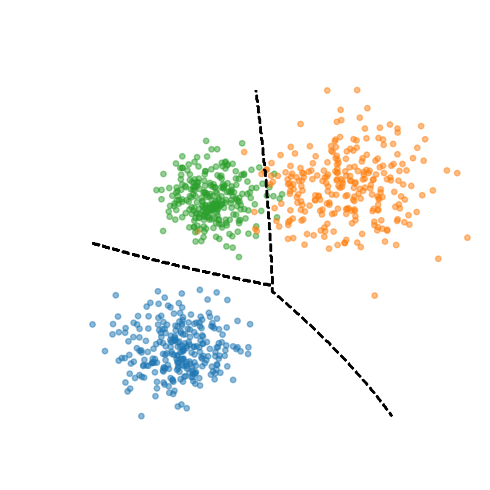

In [5]:
plot_class_example(X, y, gamma=0.1)

**Кластеризация**
- Это *неконтролируемая* задача.
- Она рассматривает только структуру данных без использования дополнительной информации (метки классов, дополнительные данные, человеческие знания и т. д.).
- Алгоритм кластеризации группирует данные вместе так, что каждая группа компактна и отделена от других.
- Кластеризация дает представление о структуре данных.
- Количество кластеризаторов часто не указывается.

In [6]:
def plot_cluster_example(X, K=2):
    kmeans = KMeans(n_clusters=K, random_state=0, n_init="auto").fit(X)
    clust_lab = kmeans.labels_
    centers = kmeans.cluster_centers_

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(X[:, 0], X[:, 1], c='gray', s=15, alpha=0.5, edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    for ind,i in enumerate(centers):
            class_inds=np.where(clust_lab==ind)[0]
            max_dist=np.max(pairwise_distances(i[None, ...], X[class_inds]))
            plt.gca().add_artist(plt.Circle(i, max_dist*0.7, fill=False, color='tab:red', linewidth=2.0))

    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.title(f"{K} Clutsers")
    plt.tight_layout()
    plt.show()

- Настройка гиперпараметров алгоритмов кластеризации (и неконтролируемых подходов в целом) более критична, чем в контролируемых моделях.
- В отличие от классификации, не существует *оптимальной* конфигурации гиперпараметров.
- Здесь мы используем популярный алгоритм $k$-means.
- Попробуйте изменить количество кластеров на `K=3` и `K=4` в коде ниже.

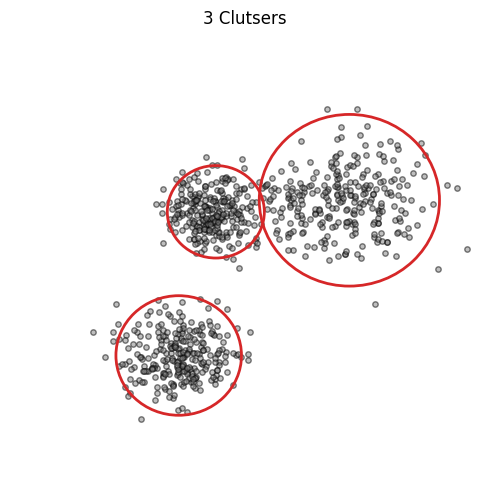

In [7]:
# We use the same data (X) as before, but not the labels (y)
plot_cluster_example(X, K=3)

### Показатели производительности

- Существует множество показателей для оценки производительности задач классификации и кластеризации.
- Наиболее полезные из них зависят от решаемой проблемы.
- Часто следует рассматривать несколько показателей одновременно.
- В этой лекции мы рассмотрим только:
- точность и оценку F1 для классификации,
- NMI для кластеризации.

#### Classification

**Точность**
- Точность классификации — это самый простой способ измерить, насколько хорошо работает модель классификации.
- Это отношение правильно предсказанных наблюдений к общему числу наблюдений.
- Определяется как:

$$\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}} =\frac{TP + TN}{TP + TN + FN +FP}$$

- Здесь $TP$ — истинно положительные результаты, $TN$ — истинно отрицательные результаты, $FP$ — ложно положительные результаты и $FN$ — ложно отрицательные результаты.

In [8]:
# Split the data in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the classifier
clf = svm.SVC(kernel="linear")
clf.fit(X_train, y_train)

# Compute predictions and accuracy
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Accuracy: 0.99


**F1 Score**
- F1 Score — это гармоническое среднее значение точности и полноты, обеспечивающее баланс между ними.
- Он используется, когда распределение классов неравномерно и вам нужна мера, которая учитывает как $FP$, так и $FN$.
- Определяется как:

$$F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

- где

$$\text{Precision} = \frac{TP}{TP + FP}$$

- и

$$\text{Recall} = \frac{TP}{TP + FN}$$

<img src="https://github.com/FilippoMB/python-time-series-handbook/blob/main/notebooks/12/media/precision-recall.png?raw=1" style="width: 60%; display: block; margin: auto;">

<div style="text-align: center; font-size: 80%">Image: <a href="https://en.wikipedia.org/wiki/Precision_and_recall">Wikipedia</a></div>

- Давайте создадим несбалансированный набор данных.

In [9]:
n_samples_1 = 2000 # Samples of class 0
n_samples_2 = 100  # Samples of class 1

X_imb, y_imb = datasets.make_blobs(
    n_samples=[n_samples_1, n_samples_2],
    centers=[[0.0, 0.0], [2.0, 2.0]],
    cluster_std=[1.5, 0.5],
    random_state=0, shuffle=False)

In [10]:
# Split the data in training and test set
X_tr_imb, X_te_imb, y_tr_imb, y_te_imb = train_test_split(X_imb, y_imb, test_size=0.2, random_state=0)

# Fit the classifier
clf = svm.SVC(kernel="linear", class_weight={1: 20}) # Try setting class_weight={1: 20}
clf.fit(X_tr_imb, y_tr_imb)

# Compute predictions and accuracy
y_pred_imb = clf.predict(X_te_imb)
print(f"Accuracy: {accuracy_score(y_te_imb, y_pred_imb):.2f}")

Accuracy: 0.89


- Оценка точности очень высокая... но все ли у нас хорошо?
- Если присмотреться, то классификатор просто присвоил все метки классу большинства.
- Это неприемлемо в случаях, когда интерес представляет класс меньшинства.
- Например, при обнаружении аномалий.

In [11]:
print(f"Predictions of class 0: {(y_pred_imb==0).sum()}, predictions of class 1: {(y_pred_imb==1).sum()}")

print(f"F1 score: {f1_score(y_te_imb, y_pred_imb):.2f}")

Predictions of class 0: 355, predictions of class 1: 65
F1 score: 0.45


#### Кластеризация

**Нормализованная взаимная информация (NMI)**
- NMI — это нормализация оценки взаимной информации (MI) для масштабирования результатов от 0 (нет взаимной информации) до 1 (идеальная корреляция).
- Он измеряет согласованность между назначениями кластеров, $C$, и метками классов $Y$:

$$\text{NMI}(C, Y) = \frac{2 \times I(C; Y)}{H(C) + H(Y)}$$

- где $I(C; Y)$ — это MI между кластерами и метками, а $H(C)$ и $H(Y)$ — это энтропии $X$ и $Y$ соответственно.
- Обратите внимание, что метки классов используются не для формирования кластеров, а только для оценки результатов.
- Если метки классов недоступны, можно все равно сформировать кластеры, но не вычислять NMI.

In [12]:
# NMI for k-means with different values of k
clust_lab = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X).labels_
print(f"K=2, NMI: {v_measure_score(clust_lab, y):.2f}")

clust_lab = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X).labels_
print(f"K=3, NMI: {v_measure_score(clust_lab, y):.2f}")

clust_lab = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(X).labels_
print(f"K=4, NMI: {v_measure_score(clust_lab, y):.2f}")

K=2, NMI: 0.73
K=3, NMI: 0.92
K=4, NMI: 0.84


---

## Similarity and dissimilarity measures

### Меры несходства

- Количественно определите, насколько различны два объекта: чем выше их несходство, тем они более различны.
- Меры несходства имеют решающее значение для различения отдельных групп данных или выявления выбросов.
- Наиболее распространенной линейной мерой несходства является евклидово расстояние:

$$d(\mathbf{x}, \mathbf{y}) = \| \mathbf{x} - \mathbf{y} \|_2$$

- Также важно расстояние Махаланобиса:

$$d(\mathbf{x}, \mathbf{y}) = \sqrt{(\mathbf{x} - \mathbf{y})^\top \Sigma^{-1}(\mathbf{x} - \mathbf{y})}$$

- которое сводится к евклидову расстоянию, когда ковариационная матрица равна $\Sigma^{-1}=\mathbf{I}$.

### Меры сходства

- Мера сходства количественно установлена, хотя два объекта похожи: чем значение, тем больше похожих выше объектов.
- Эти меры необходимы в алгоритмах, которые учитывают *близость* или *сходства* для принятия решений, например, в рекомендательном контексте.
- Примером схода мерства является косинусное сходство:

$$s(\mathbf{x}, \mathbf{y}) = \frac{\mathbf{x}^\top \mathbf{y}}{\|\mathbf{x}|\ \| \mathbf{y}\|}$$

- Другой пример — корреляция коэффициента Пирсона, статистика в статистике для измерения линейных корреляций между двумя переменными:

$$s(\mathbf{x}, \mathbf{y}) = \frac{\text{cov}(\mathbf{x}, \mathbf{y})}{\sigma_\mathbf{x}, \sigma_\mathbf{y}}$$

### Линейные и нелинейные меры
- Меры, которые мы написали до сих пор, являются *линейными*.
- Это означает, что их вычисление следует линиями в зависимости от данных.
- Некоторые меры, напротив, являются *нелинейными*, то есть связь между мерой и данными не должна быть по прямой линии.
- **Ядра** являются примерами нелинейных мер подобия.
- Самым известным источником является радиальная базисная функция (RBF):

$$s(\mathbf{x}, \mathbf{y}) = \text{exp}\left( -\gamma \| \mathbf{x} - \mathbf{y} \|^2 \right)$$

- Параметр $\gamma$ - это *ширина ядра*, которая управляет стандартным отклонением гауссовой функции.
- Правильная настройка имеет решающее значение для определения расстояний: меньшие значения будут учитывать отношения между удаленными объектами.

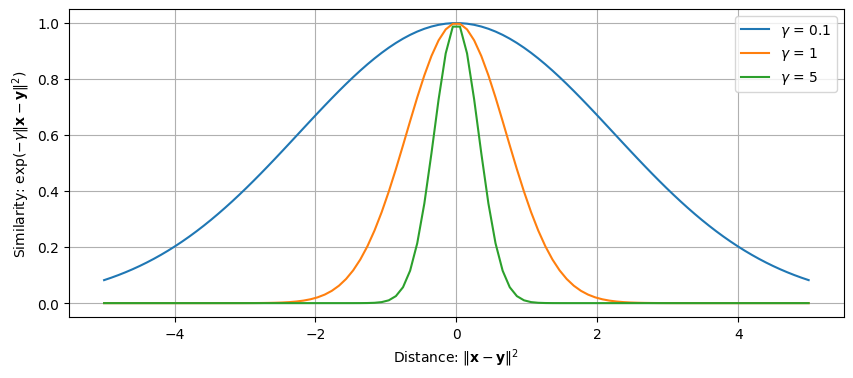

In [13]:
values = np.linspace(-5, 5, 100)
gamma_vals = [0.1, 1, 5]
plt.figure(figsize=(10, 4))
for gamma in gamma_vals:
    similarity = np.exp(-gamma * values**2)
    plt.plot(values, similarity, label=f'$\gamma$ = {gamma}')
plt.xlabel('Distance: $\|\mathbf{x} - \mathbf{y}\|^2$')
plt.ylabel('Similarity: $\exp(-\gamma\|\mathbf{x} - \mathbf{y}\|^2)$')
plt.legend()
plt.grid(True)
plt.show()

- Выбор меры сходства или различия имеет решающее значение в задачах классификации и кластеризации.
- Мера напрямую влияет на то, насколько хорошо алгоритм может идентифицировать структуру данных.
- Неправильный выбор может привести к плохой классификации или производительности кластеризации, поскольку мера может не отражать фактические связи между точками данных.

### Влияние на классификацию

- Далее мы сгенерируем некоторые игрушечные данные и вычислим матрицу сходства, используя линейную и нелинейную меру.
- В качестве линейной меры мы будем использовать косинусное сходство.
- В качестве нелинейной меры мы будем использовать ядро ​​RBF.

In [14]:
X, y = datasets.make_circles(noise=0.2, factor=0.5, random_state=1, n_samples=200) # Create toy data
X_train , X_test , y_train, y_test = train_test_split(X, y, random_state=0) #Train-test split

# Cosine similarity matrix
cosine_train = cosine_similarity(X_train)

# RBF similarity matrix
rbf_kernel_train = pairwise_kernels(X_train, metric='rbf', gamma=0.5)

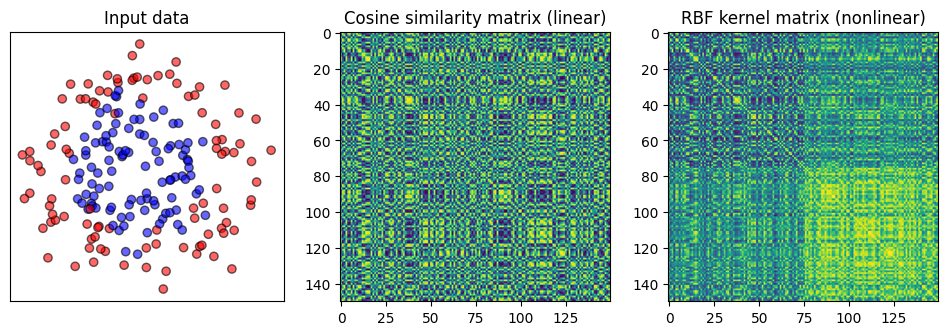

In [15]:
# Plot the data
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
axes[0].set_title("Input data")
axes[0].scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, alpha=0.6, edgecolors="k")
axes[0].set_xticks(())
axes[0].set_yticks(())

# Plot the cosine matrix
idx = np.argsort(y_train)
axes[1].imshow(cosine_train[idx][:, idx], cmap='viridis')
axes[1].set_title("Cosine similarity matrix (linear)")

# Plot the RBF matrix
axes[2].imshow(rbf_kernel_train[idx][:, idx], cmap='viridis')
axes[2].set_title("RBF kernel matrix (nonlinear)");

- Мы видим, что два класса кажутся более разделенными при использовании нелинейного сходства.

- Далее мы обучим классификатор SVM, который использует эти две меры сходства.
- Мы рассмотрим границы решений, изученные классификатором, и вычислим его производительность на тестовых данных.
- Для ядра RBF мы будем использовать как $\gamma=0.5$, так и $\gamma=0.1$.

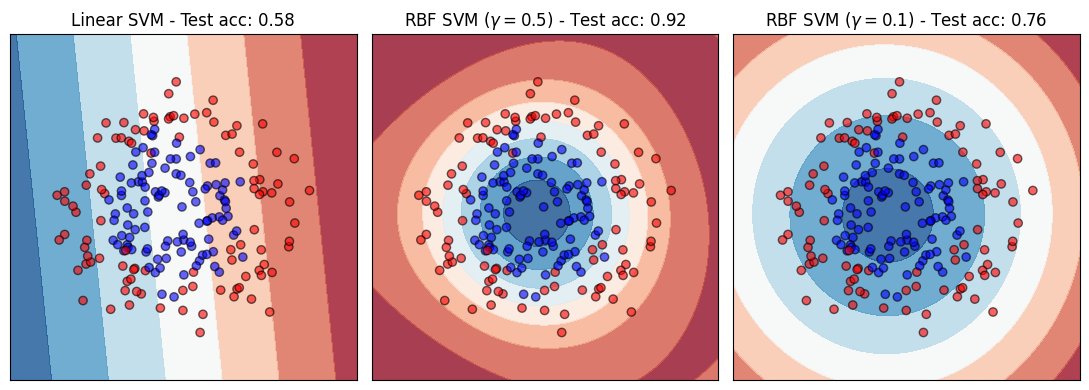

In [16]:
classifiers = [svm.SVC(kernel="linear"), svm.SVC(gamma=0.5), svm.SVC(gamma=0.1)]
names = ["Linear SVM", "RBF SVM ($\gamma=0.5$)", "RBF SVM ($\gamma=0.1$)"]
figure = plt.figure(figsize=(11, 4))
for i, (name, clf) in enumerate(zip(names, classifiers)):
    ax = plt.subplot(1,3,i+1)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    DecisionBoundaryDisplay.from_estimator(
        clf, X, cmap=plt.cm.RdBu, alpha=0.8, ax=ax, eps=0.5)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors="k", alpha=0.6)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name + f" - Test acc: {score:.2f}")
plt.tight_layout()
plt.show()

- В этом случае влияние использования различных мер сходства также весьма велико.

#### Эффект кластеризации

- Кластеризация как задача без учителя приведет к увеличению метрик (не)схожести.
- Увеличение времени обучения не приводит к улучшению метрик (не)схожести.
- Результат кластеризации будет сильно зависеть от меткик (не)схожести.

- далее мы посмотрим иерархическую кластеризацию *hierarchical clustering* (HC).
- Идея иерархической кластеризации заключается в формировании кластеров путем группировки объектов, которые находятся в определенной окрестности с заданным радиусом.
- В начале радиус окрестности очень мал, и формируется большое количество кластеров.
- С увеличение радиуса, кластеры  укрупняются путем добавления в них других точек, и, соответственно, количество кластеров существенно уменьшается.

- Рассмотрим следующие данные. В качестве меры расстояния будем использовать Евклидово расстояние..
- В качестве иерархического алгоритма будем использовать *Ward Linkage*, который объединяет кластеры оптимизируя критерий минимальных вариаций [minimum variance criterion](https://en.wikipedia.org/wiki/Ward%27s_method#The_minimum_variance_criterion).
- На каждом шаге алгоритм будет нахожить пару кластеров, объединение которых приведет к минимальному увеличению в общей внутри-кластеровой вариации.

In [17]:
X, y = datasets.make_blobs(n_samples=1500, centers=4,
                           cluster_std=[1.7, 2.5, 0.5, 1.5], random_state=2)
X = StandardScaler().fit_transform(X) # Normalizing the data facilitates setting the radius

# Compute the distance matrix
Dist = pairwise_distances(X, metric="sqeuclidean")
distArray = ssd.squareform(Dist)

# Compute the hierarchy of clusters
Z = linkage(distArray, 'ward')

- Используя разный радиус (трешхолд), мы получим разные деления на кластеры.
- Попробуем в качестве трешхолдов`t=10` и `t=30`.

In [18]:
partition_1 = fcluster(Z, t=10, criterion="distance")
print("Partition 1: %d clusters"%len(np.unique(partition_1)))

partition_2 = fcluster(Z, t=30, criterion="distance")
print("Partition 1: %d clusters"%len(np.unique(partition_2)))

Partition 1: 8 clusters
Partition 1: 4 clusters


In [19]:
def plot_clusters(data, clusters=None, title=None, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(5, 5))
    color = 'gray' if clusters is None else plt.cm.tab10(clusters)
    ax.scatter(data[:, 0], data[:, 1], c=color, s=15, alpha=0.5)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
    ax.set_title(title)

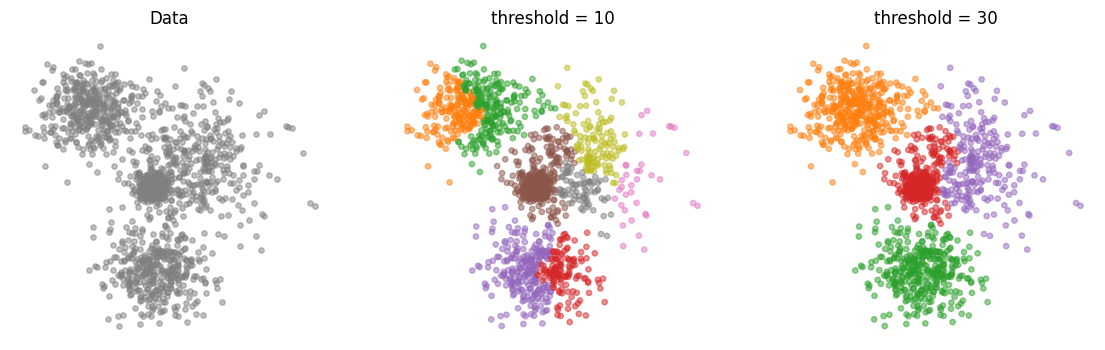

In [20]:
_, axes = plt.subplots(1,3, figsize=(14,4))
plot_clusters(X, title="Data", ax=axes[0])
plot_clusters(X, title="threshold = 10", clusters=partition_1, ax=axes[1])
plot_clusters(X, title="threshold = 30", clusters=partition_2, ax=axes[2])

- Иерархическую кластеризацию можно визуализировать.
- Можно раскрасить каждое ответвление в зависимости от значения трешхолда.
- И это очень удобно для исследования структуры данных и разбиения их на кластеры.

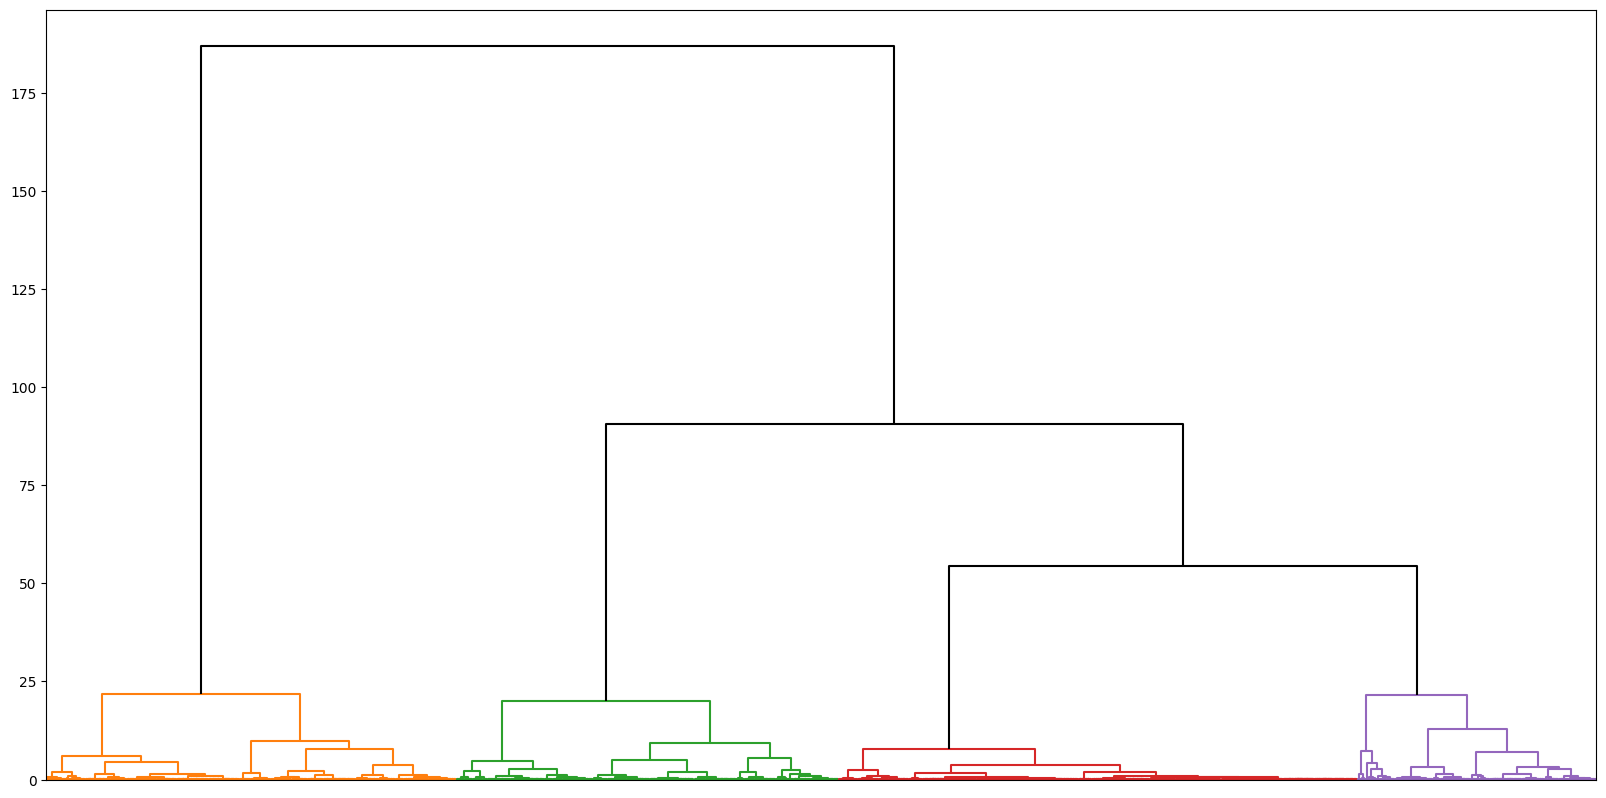

In [21]:
fig = plt.figure(figsize=(20, 10))
dn = dendrogram(Z, color_threshold=30, above_threshold_color='k',
                show_leaf_counts=False)
plt.xticks([])
plt.show()

- Partitions that persist for broad ranges of values of the threshold are those that characterize the dataset the most.

- Finally, let's see the effect of using different distance metrics.
- We will use an RBF kernel as before and a Mahalanobis distance that weights each feature differently.

In [22]:
# Compute the RBF (note that we must convert it to a distance)
rbf_kernel = pairwise_kernels(X, metric='rbf', gamma=1.0) # compute the rbf similarity
rbf_kernel = rbf_kernel + rbf_kernel.T # make symmetric
rbf_kernel /= rbf_kernel.max() # normalize to [0, 1]
rbf_dist = 1.0 - rbf_kernel # convert to distance
np.fill_diagonal(rbf_dist, 0) # due to numerical errors, the diagonal might not be 0

# Compute the partition
distArray = ssd.squareform(rbf_dist)
Z = linkage(distArray, 'ward')
partition_3 = fcluster(Z, t=3, criterion="distance")

In [23]:
# Mahalanobis distance that assigns different weights to the features
weights = np.array([1, 0.1])
Dist = pairwise_distances(X, metric="mahalanobis", VI=np.diag(1/weights**2))

# Compute the partition
distArray = ssd.squareform(Dist)
Z = linkage(distArray, 'ward')
partition_4 = fcluster(Z, t=30, criterion="distance")

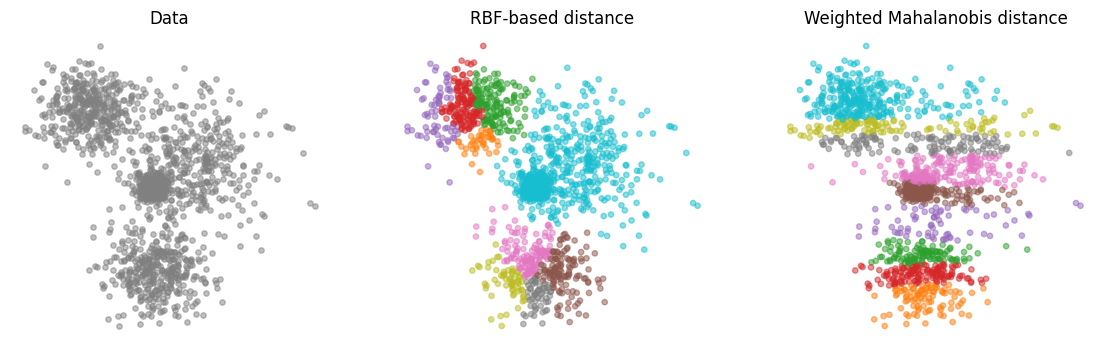

In [24]:
_, axes = plt.subplots(1,3, figsize=(14,4))
plot_clusters(X, title="Data", ax=axes[0])
plot_clusters(X, title="RBF-based distance", clusters=partition_3, ax=axes[1])
plot_clusters(X, title="Weighted Mahalanobis distance", clusters=partition_4, ax=axes[2])

- К настоящему моменту должно быть ясно влияние меры (несходства) на классификацию и кластеризацию.
- Но как измерить расстояние между временными рядами?

---

## Time series similarity

- Мы рассмотрим 3 семейства подходов к вычислению расстояния между временными рядами:
    - Метрики, основанные на выравнивании.
    - Ядра временных рядов.
    - Векторные расстояния на вложениях временных рядов.
- Каждый подход имеет свои плюсы и минусы.
- Далее мы рассмотрим одного представителя для каждого семейства.

### Многомерные временные ряды (MTS)

- Подходы, которые мы обсуждаем далее, могут быть применены к наборам данных MTS.
- MTS представлен матрицей $\mathbf{X} \in \mathbb{R}^{T \times V}$, где $T$ — это количество временных шагов, а $V$ — это переменные.
- Весь набор данных может быть представлен 3-мерным массивом `X` размером `[N, T, V]`.
- В настройке классификации $i$-й MTS `X[i,:,:]` связан с меткой класса `y[i]`.

<img src="data\l7\mts_data.png" style="ширина: 60%; дисплей: блок; поля: авто;">

**Пример:**
- Рассмотрим набор данных MTS [uWave](https://ieeexplore.ieee.org/document/4912759).
- Каждый MTS представляет измерения $(x,y,z)$ акселерометра, надетого при выполнении одного из следующих жестов.
- Точка — начальная точка, стрелка — конечная точка.

<img src="data\l7\UWaveGestureLibrary.jpg" style="width: 20%; display: block; margin: auto;">

In [25]:
def plot_uwave():
    X, Y, _, _ = DataLoader().get_data('UWAVE')
    _, axes = plt.subplots(3, 8, figsize=(15, 5), subplot_kw={'projection': '3d'})
    for i in range(len(np.unique(Y))):
        idx = np.where(Y == i+1)[0][:3]
        for j, id in enumerate(idx):
            axes[j,i].plot(X[id, :, 0], X[id, :, 1], X[id, :, 2], color=plt.cm.tab10(i))
            axes[j,i].set_xticks(())
            axes[j,i].set_yticks(())
            axes[j,i].set_zticks(())
            axes[j,i].spines[['right', 'left', 'top', 'bottom']].set_visible(False)
            if j == 0:
                axes[j,i].set_title(f"Class {i+1}")
    plt.tight_layout()
    plt.show()

Loaded UWAVE dataset.
Number of classes: 8
Data shapes:
  Xtr: (200, 315, 3)
  Ytr: (200, 1)
  Xte: (428, 315, 3)
  Yte: (428, 1)


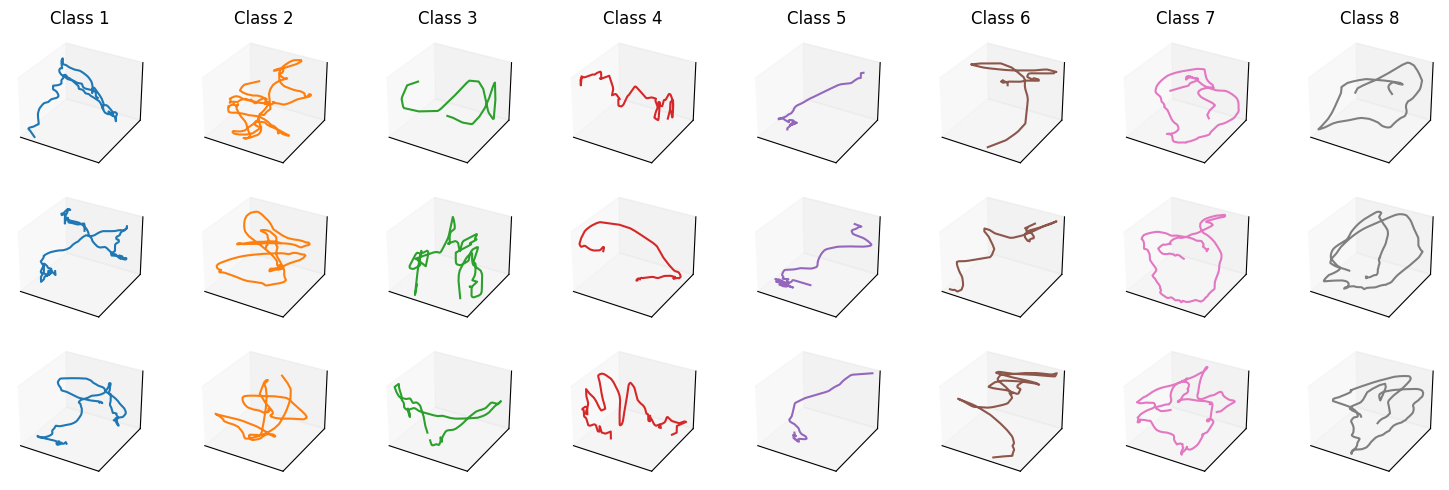

In [26]:
plot_uwave()

---

## Метрика, основанная на выравнивании: Dynamic Time Warping (DTW)

- Метрика на основе выравнивания опирается на временное выравнивание двух временных рядов для оценки их сходства.
- Одним из наиболее ярких представителей этого класса является динамическое искажение времени (DTW).
- Идея DTW заключается в том, чтобы сначала выровнять два временных ряда, а затем вычислить евклидово расстояние между сопоставленными элементами.

- Let's first consider a naïve approach.
- We compute a distance between all the time steps of two time series $\boldsymbol{x}$ and $\boldsymbol{y}$ of length $T_x$ and $T_y$, respectively:

$$d(\boldsymbol{x}, \boldsymbol{y}) = \sum \limits_{t=1}^{\min(T_x, T_y)} \|x(t) - y(t)\|_2$$

- If the two time series are very similar but slightly disaligned, it will produce a large distance.

<img src="https://github.com/FilippoMB/python-time-series-handbook/blob/main/notebooks/12/media/DTW_idea_1.gif?raw=1" style="width: 40%; display: block; margin: auto;">

- DTW disregards the exact timestamps at which the observations occur.
- DTW seeks for the *temporal alignment* (a matching between time indexes of the two time series) that minimizes Euclidean distance between the aligned series.

<img src="https://github.com/FilippoMB/python-time-series-handbook/blob/main/notebooks/12/media/DTW_idea_2.gif?raw=1" style="width: 40%; display: block; margin: auto;">

### DTW algorithm

- DTW solves the following optimization problem:

$$\text{DTW}(\boldsymbol{x}, \boldsymbol{y}) = \min \limits_{\pi \in \mathcal{P}(\boldsymbol{x}, \boldsymbol{y})} \left( \sum \limits_{(i,j) \in \pi} d(x(i), y(j))  \right)$$

- $\pi$ is an *alignment path* of length $K$, i.e., a sequence of index pairs.
- $\mathcal{P}(\boldsymbol{x}, \boldsymbol{y})$ is the set of all admissible paths.

An admissible path should satisfy the following conditions:

1. The beginning and the end of the two time series are matched together.
    - $\pi_{1} = (1,1)$
    - $\pi_{K} = (T_x, T_y)$
    
<img src="https://github.com/FilippoMB/python-time-series-handbook/blob/main/notebooks/12/media/start_end.png?raw=1" style="width: 40%; display: block; margin: auto;">

2. The sequence is monotonically increasing in both $i$ and $j$ and all time series indexes should appear at least once.
    - $i_{k-1} \leq i_k \leq i_{k-1}+1$
    - $j_{k-1} \leq j_k \leq j_{k-1}+1$
    
<img src="https://github.com/FilippoMB/python-time-series-handbook/blob/main/notebooks/12/media/conditions.png?raw=1" style="width: 40%; display: block; margin: auto;">

- The DTW path can be represented by a binary matrix $\mathbf{P}_\pi$ whose non-zero entries are those corresponding to a matching between time series elements:

$$(\mathbf{P}_\pi)_{i,j} = \begin{cases}1 &= \text{if}\; (i,j)\in \pi \\ 0 &= \text{otherwise}\end{cases}$$

- Using the matrix notation, DTW can be rewritten as

$$\text{DTW}(\boldsymbol{x}, \boldsymbol{y}) = \min \limits_{\pi \in \mathcal{P}(\boldsymbol{x}, \boldsymbol{y})} \langle \mathbf{P}_\pi, \mathbf{D}_{\boldsymbol{x}, \boldsymbol{y}} \rangle$$

- where the $(i,j)^{th}$ element of $\mathbf{D}_{\boldsymbol{x}, \boldsymbol{y}} \in \mathbb{R}^{T_x \times T_y}$ stores the distance $d(x(i), y(j))$.

<img src="https://github.com/FilippoMB/python-time-series-handbook/blob/main/notebooks/12/media/matrix.png?raw=1" style="width: 60%; display: block; margin: auto;">

#### Finding the optimal path

- First, we fill-up the cost matrix $\mathbf{D}_{\boldsymbol{x}, \boldsymbol{y}}$.

<img src="https://github.com/FilippoMB/python-time-series-handbook/blob/main/notebooks/12/media/cost.gif?raw=1" style="width: 30%; display: block; margin: auto;">

- Then, we start traversing the matrix from the top-left corner $(1,1)$ to the bottom-right one $(T_x, T_y)$.
- Excluding the borders, at each step we have three options to decide where to go.
- Each path results in a different cost.
- The optimal path is the one with minimum cost... 🤔 But how to find it?

<img src="https://github.com/FilippoMB/python-time-series-handbook/blob/main/notebooks/12/media/path.gif?raw=1" style="width: 30%; display: block; margin: auto;">

- Нам нужно вычислить стоимость для каждого возможного пути.
- Когда $T_x=T_y$, общее количество путей составляет $\mathcal{O}\left(\frac{(3+2\sqrt{2})^{T_x}}{\sqrt{T_x}}\right)$.
- Это большое число: рассмотреть их все нереально.

- Существует много путей, которые разделяют одни и те же разделы.
- Чтобы сделать задачу разрешимой, мы должны избегать повторного вычисления одних и тех же путей снова и снова.

<img src="data\l7\redundant.png" style="width: 30%; display: block; margin: auto;">

- Мы можем использовать *рекурсию*, метод динамического программирования, который разбивает сложную задачу на более простые подзадачи.
- Каждая подзадача решается только один раз, и решение сохраняется в памяти.
- Когда подзадача встречается снова, ее решение извлекается, а не пересчитывается.
- Это значительно сокращает количество вычислений, устраняя избыточность.

- Рекурсивный алгоритм имеет сложность $\mathcal{O}(T_x T_y)$ и формулируется следующим образом:

```python
def DTWDistance(x, y):
  for i in range(len(x)):
    for j in range(len(y)):
      DTW[i, j] = d(x[i], y[j])
      if i > 0 or j > 0:
        DTW[i, j] += min(
          DTW[i-1, j  ] if i > 0             else inf,
          DTW[i  , j-1] if j > 0             else inf,
          DTW[i-1, j-1] if (i > 0 and j > 0) else inf
        )
  return DTW[-1, -1]
```

- Идея заключается в том, что каждый блок $(i,j)$ рекурсивно запрашивает у своих предшественников $(i-1, j)$, $(i, j-1)$ и $(i-1, j-1)$ стоимость их достижения.
- Запрос распространяется обратно к источнику $(1,1)$, который возвращает первый ответ.
- Затем ответ распространяется вперед всем запрашивающим, которые обновляют ответ своей стоимостью.

<img src="data\l7\recursion.gif" style="width: 40%; display: block; margin: auto;">

#### Свойства DTW

- В примере ниже показано, как изменяется DTW, когда две кривые одновременно переносятся и растягиваются/сжимаются.

<img src="data\l7\warping.gif" style="width: 45%; display: block; margin: auto;">

- Обратите внимание, что на расстояние влияет только часть «растяжения/сжатия».
- Фактически, DTW инвариантен к трансляции.

<img src="data\l7\warping_fix.gif" style="width: 45%; display: block; margin: auto;">

- Обратите внимание, что можно добавлять ограничения, которые генерируют стоимость, если перевод превышает определенный предел.

<img src="data\l7\warping_constrained.gif" style="width: 45%; display: block; margin: auto;">

#### Пример DTW

- Давайте посмотрим на DTW в действии, начав с простого примера.
- Мы генерируем две группы временных рядов, используя два разных процесса AR(1).

In [27]:
T = 100 # Length of the time series
N = 30  # Time series per set

# Generate the first set of time series
Y1 = np.zeros((T, N))
for i in range(N):
    Y1[:,i] = sm.tsa.arma_generate_sample(ar=[1, -.9], ma=[1], nsample=T, scale=1)

# Generate the second set of time series
Y2 = np.zeros((T, N))
for i in range(N):
    Y2[:,i] = sm.tsa.arma_generate_sample(ar=[1, .9], ma=[1], nsample=T, scale=1)

- Давайте представим, как выглядят две группы, построив график среднего значения и стандартного отклонения для каждого набора.

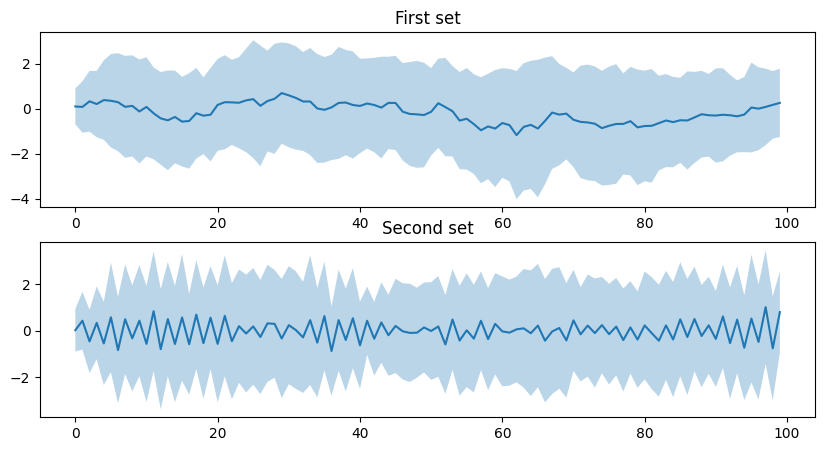

In [28]:
fig, axes = plt.subplots(2,1, figsize=(10, 5))
axes[0].plot(np.mean(Y1, axis=1))
axes[0].fill_between(range(T), np.mean(Y1, axis=1) - np.std(Y1, axis=1), np.mean(Y1, axis=1) + np.std(Y1, axis=1), alpha=0.3)
axes[0].set_title("First set")
axes[1].plot(np.mean(Y2, axis=1))
axes[1].fill_between(range(T), np.mean(Y2, axis=1) - np.std(Y2, axis=1), np.mean(Y2, axis=1) + np.std(Y2, axis=1), alpha=0.3)
axes[1].set_title("Second set")
plt.show()

- Мы можем визуализировать путь $\pi$ на матрице стоимости $\mathbf{D}_{\boldsymbol{x}, \boldsymbol{y}}$ для сгенерированного нами временного ряда.
- Во-первых, пусть $\boldsymbol{x}$ и $\boldsymbol{y}$ будут двумя временными рядами из одной группы.
- Обратите внимание, как путь $\pi$ пересекает более темные области, соответствующие меньшим значениям различия.

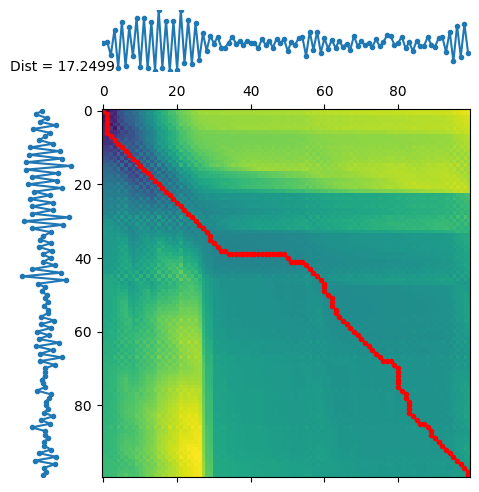

In [29]:
s1 = Y2[:,1]
s2 = Y2[:,2]
fig = plt.figure(figsize=(5, 5))
d, paths = dtw.warping_paths(s1, s2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, best_path, figure=fig);

- Затем мы выбираем $\boldsymbol{x}$ и $\boldsymbol{y}$ из двух разных групп.
- Мы видим, как в этом случае различие намного выше, и путь $\pi$ значительно меняется.

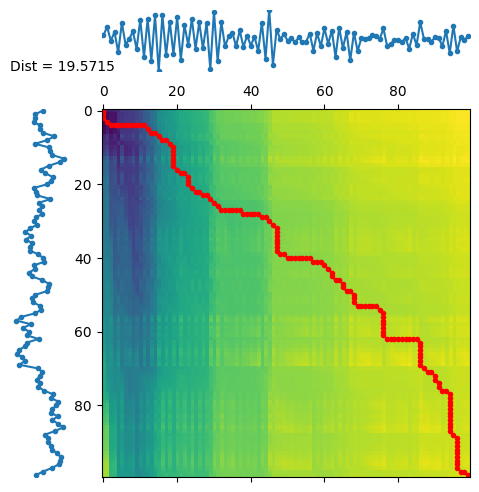

In [30]:
s1 = Y1[:,1]
s2 = Y2[:,1]
fig = plt.figure(figsize=(5, 5))
d, paths = dtw.warping_paths(s1, s2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, best_path, figure=fig);

- Наконец, мы вычисляем расстояние DTW между всеми временными рядами в двух наборах.

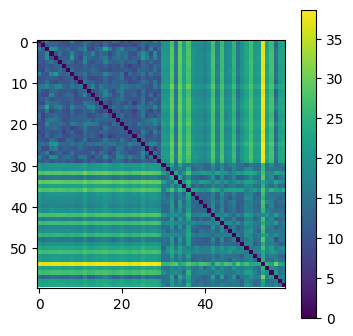

In [31]:
# Concatenate the two sets of time series
Y = np.concatenate((Y1, Y2), axis=1).T

# Compute the distance matrix
dtw_dist = dtw.distance_matrix_fast(Y)

# Plot the distance matrix
plt.figure(figsize=(4,4))
plt.imshow(dtw_dist, cmap='viridis')
plt.colorbar()
plt.show()

- Мы видим четкую блочную структуру.
- Различия меньше между временными рядами одной и той же группы.

- Для сравнения мы также вычисляем евклидово расстояние между временными рядами.

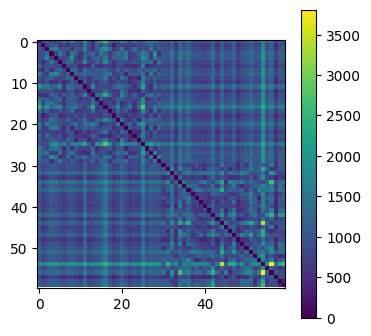

In [32]:
# compute euclidean distance between the time series
euc_dist = pairwise_distances(Y, metric="sqeuclidean")
plt.figure(figsize=(4,4))
plt.imshow(euc_dist, cmap='viridis')
plt.colorbar()
plt.show()

- На этот раз матрица различий менее структурирована и сложнее увидеть разделение на две группы.
- Как и ожидалось, евклидово расстояние менее подходит для такого типа данных.

### Classification with DTW

- Теперь перейдем к реальной задаче классификации.
- Мы будем использовать один из следующих наборов данных.

In [33]:
DataLoader().available_datasets()

Available datasets:

AtrialFibrillation
ArabicDigits
Auslan
CharacterTrajectories
CMUsubject16
ECG2D
Japanese_Vowels
KickvsPunch
Libras
NetFlow
RobotArm
UWAVE
Wafer
Chlorine
Phalanx
SwedishLeaf


In [34]:
Xtr, Ytr, Xte, Yte = DataLoader().get_data('Japanese_Vowels')

Loaded Japanese_Vowels dataset.
Number of classes: 9
Data shapes:
  Xtr: (270, 29, 12)
  Ytr: (270, 1)
  Xte: (370, 29, 12)
  Yte: (370, 1)


In [35]:
# Concatenate X and Xte
X = np.concatenate((Xtr, Xte), axis=0)
Y = np.concatenate((Ytr, Yte), axis=0)

In [36]:
# Compute the dissimilarity matrix
dtw_dist = dtw_ndim.distance_matrix_fast(X)
print("dist shape:", dtw_dist.shape)

dist shape: (640, 640)


- Обратите внимание, что мы объединили обучающий и тестовый наборы перед вычислением расстояний. Почему?
- Далее мы будем использовать SVC с предварительно вычисленным ядром, т. е. пользовательскую матрицу сходства (подробнее [здесь](https://scikit-learn.org/stable/modules/svm.html#custom-kernels)).
- Нам нужно вычислить два набора расстояний, чтобы предоставить информацию классификатору.

- Для обучения нам нужны расстояния между элементами в обучающем наборе.
- Назовем матрицу, содержащую эти расстояния, **tr-tr**.
- Для тестирования нам нужны расстояния между элементами обучающего и тестового наборов.
- Эти расстояния находятся в матрице **te-tr**.

<img src="data\l7\dist_matrix.png" style="width: 40%; display: block; margin: auto;">

- К сожалению, `dtw_ndim.distance_matrix_fast` не вычисляет расстояния между двумя разными наборами, что означает, что он не может вычислить **te-tr** явно.
- В нашем случае, поскольку набор данных небольшой, мы можем вычислить всю матрицу расстояний и оставить только нужные нам части.
- Обратите внимание, что некоторые вычисления (**tr-te** и **te-te**) *тратятся впустую*.
- Если вычислительные ресурсы ограничены или набор данных слишком большой, лучше выполнить итерацию по элементам обучающего и тестового наборов и вычислить только те расстояния, которые нам действительно нужны.

- Ядро представляет собой матрицу подобия с элементами в [0,1].
- Мы можем получить ее с помощью следующего преобразования.

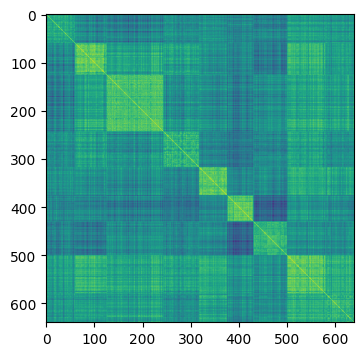

In [37]:
dtw_sim = 1.0 - dtw_dist/dtw_dist.max()

# Plot the similarity matrix
idx_sorted = np.argsort(Y[:,0])
dtw_sim_sorted = dtw_sim[:,idx_sorted][idx_sorted,:]
fig =  plt.figure(figsize=(4,4))
plt.imshow(dtw_sim_sorted);

- Далее получим кернел, который нам действительно нужен.

In [38]:
sim_trtr = dtw_sim[:Xtr.shape[0], :Xtr.shape[0]]
print(sim_trtr.shape)

sim_tetr = dtw_sim[Xtr.shape[0]:, :Xtr.shape[0]]
print(sim_tetr.shape)

(270, 270)
(370, 270)


- Теперь мы обучаем классификатор и оцениваем метрики на тестовых данных.

In [39]:
clf = svm.SVC(kernel='precomputed', C=1).fit(sim_trtr, Ytr.ravel())
y_pred = clf.predict(sim_tetr)
accuracy = accuracy_score(Yte.ravel(), y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 97.30%


#### $k$-NN classifier

- Один раз вычесленная, матрица сходжести или расстояния может быть использована в других классификаторах.
- Например, $k$-NN классификатор, который достаточно просто реализовать:
    - семпл из тестового набора относится к тому классу, к которому относится большинство $k$ соседей из трейна.
- В нашем случае соседи будут идентифицироваться по расстоянию DTW.

In [40]:
# In this case we use the DTW distance directly.
dtw_trtr = dtw_dist[:Xtr.shape[0], :Xtr.shape[0]]
dtw_tetr = dtw_dist[Xtr.shape[0]:, :Xtr.shape[0]]

In [41]:
neigh = KNeighborsClassifier(n_neighbors=3, metric='precomputed') # specify k=3
neigh.fit(dtw_trtr, Ytr.ravel())
y_pred = neigh.predict(dtw_tetr)
accuracy = accuracy_score(Yte.ravel(), y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 96.49%


### Кластеризация с DTW

- Чтобы сделать кластеризацию, мы можем использовать HC.
- Как и раньше, мы будем использовать Ward Linkage для создания иерархии `Z`.
- И мы должны передать матрицу DTW dissimilarity.

In [42]:
distArray = ssd.squareform(dtw_dist)
Z = linkage(distArray, 'ward')

- Чтобы получить кластеры, необходимо задать трешхолд.
- А чтобы выбрать трешхолд, можно посмотреть на дендрограмму иерархии  `Z` .

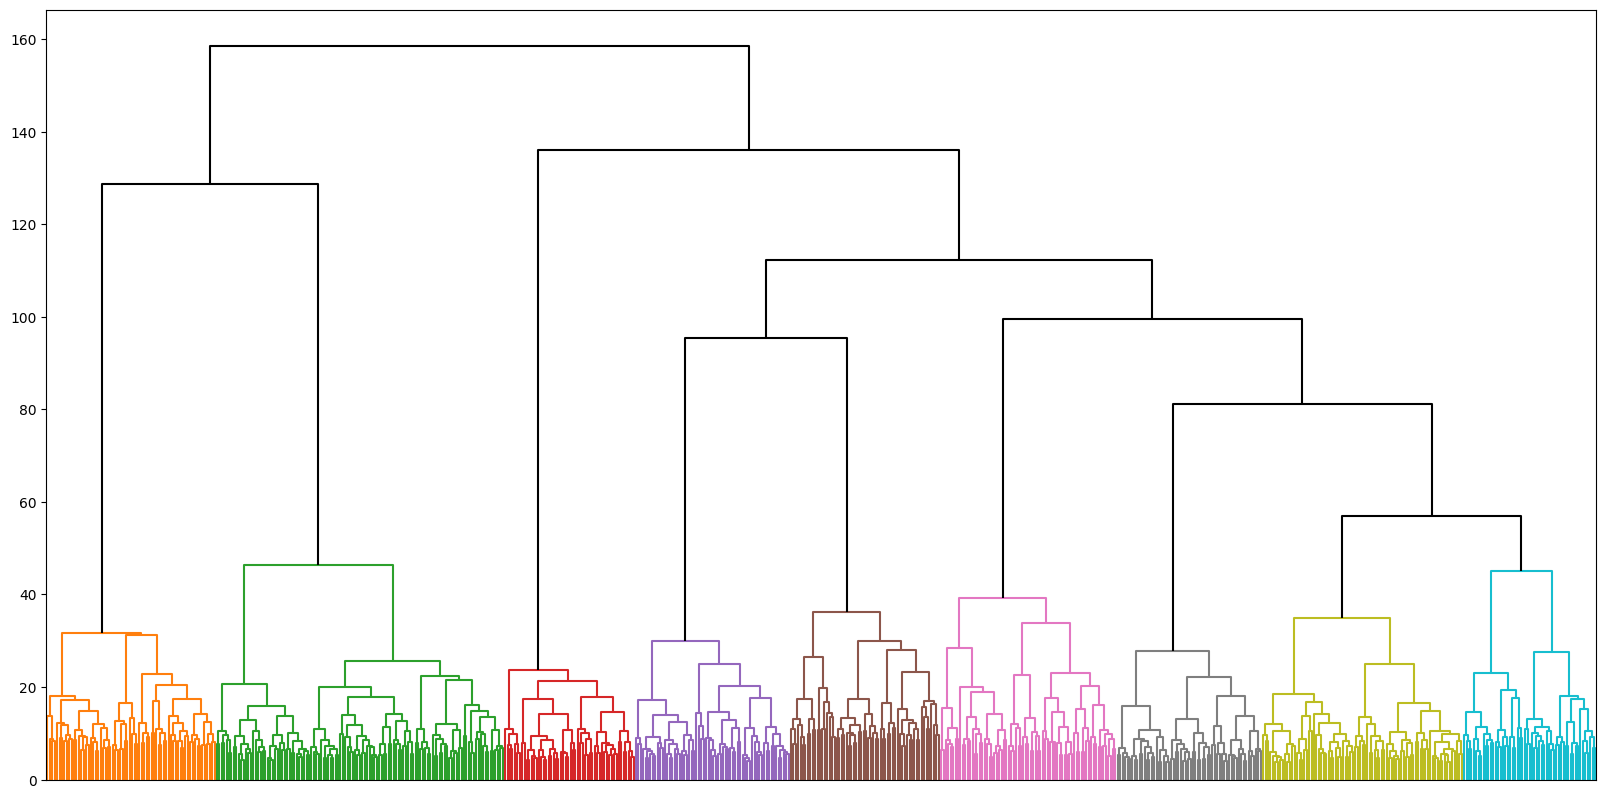

In [43]:
fig = plt.figure(figsize=(20, 10))
dn = dendrogram(Z, color_threshold=50, above_threshold_color='k',
                show_leaf_counts=False)
plt.xticks([]);

- Значение трешхолда между 50 и 60 выглядит так, как будто даст стабильное разделение.

In [44]:
partition = fcluster(Z, t=55, criterion="distance")
print(f"Found {len(np.unique(partition))} clusters")

Found 9 clusters


- В конце мы считаем, насколько деление на кластеры соответствуют реальным меткам классов.

In [45]:
print(f"DTW-based clustering NMI: {v_measure_score(partition, Y.ravel()):.2f}")

DTW-based clustering NMI: 0.95


### Визуализация через уменьшение размерности

- Как мы можем визуализировать наш набор данных осмысленным образом?
- У нас есть $N$ выборок, каждая из которых представляет собой многомерный временной ряд размером $T \times V$.
- Построить их график напрямую невозможно.

- На предыдущих лекциях мы познакомились с PCA, методом уменьшения размерности данных.
- Уменьшение размерности данных до 2 или 3 сделало бы визуализацию возможной.

- Если данные являются векторами, т. е. $\mathbf{X} \in \mathbb{R}^{N \times V}$, PCA сначала вычисляет эмпирическую корреляционную матрицу $\mathbf{X}^\top\mathbf{X} \in \mathbb{R}^{V \times V}$, которая фиксирует ковариацию между признаками в наборе данных.
- PCA использует эту информацию для проецирования данных на направления (главные компоненты), которые максимизируют дисперсию.
- К сожалению, эмпирическая корреляция бессмысленна, если данные являются временными рядами, поскольку нас не интересует корреляция отдельных временных шагов.
- Проблема еще больше усложняется, если временные ряды являются многомерными.

- PCA может вычислять главные компоненты также посредством собственного разложения матрицы Грама $\mathbf{X}\mathbf{X}^\top \in \mathbb{R}^{N \times N}$.
- Матрица Грама является ковариационной матрицей, т. е. матрицей подобия, которая фиксирует линейные отношения между выборками данных.
- Как и в случае с евклидовым расстоянием, линейная ковариационная матрица не подходит для временных рядов.
- Однако мы можем заменить ковариацию другой матрицей ядра, например, полученной из DTW.
- Алгоритм PCA, который использует матрицы ядра, называется [KernelPCA](https://scikit-learn.org/stable/auto_examples/decomposition/plot_kernel_pca.html).

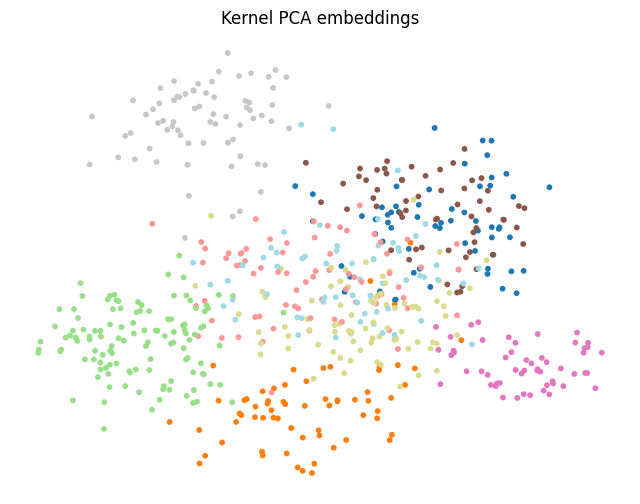

In [46]:
kpca = KernelPCA(n_components=2, kernel='precomputed')
embeddings_pca = kpca.fit_transform(dtw_sim)

fig =  plt.figure(figsize=(8,6))
plt.scatter(embeddings_pca[:,0], embeddings_pca[:,1], c=Y.ravel(), s=10, cmap='tab20')
plt.title("Kernel PCA embeddings")
plt.gca().spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.xticks(())
plt.yticks(());

- KernelPCA отображает каждый временной ряд в 2D-точку.
- Сходство на основе DTW хорошо отражает структуру данных и взаимосвязи между временными рядами.
- В результате KernelPCA проецирует классы в относительно хорошо разделенные группы.

---

## Time-series kernels

- Ядро для данных временных рядов — это математическая функция, используемая для измерения сходства между двумя временными рядами

$$k(\boldsymbol{x}, \boldsymbol{y}) \geq 0$$

- Мы рассмотрим ядро кластера временных рядов (TCK), которое предлагает следующие преимущества
- Подходит для многомерных временных рядов.
- Может работать с отсутствующими данными.
- Устойчив к выбору гиперпараметров.

- Для построения ядра TCK объединяет *модели гауссовых смесей (GMM)* с подходом *ансамблевого обучения*.

<img src="data\l7\tck_scheme.png" style="width: 90%; display: block; margin: auto;">

### GMM

- GMM предполагает, что все точки данных генерируются из смеси распределений Гаусса $C$ (компонентов) с неизвестными параметрами $\{ \mu_c, \Sigma_c \}_{c=1}^C$.
- GMM используются для кластеризации.
- Каждый кластер моделируется распределением Гаусса.

In [47]:
def plot_gmm(X, n_components, ax=None):

    gmm = GaussianMixture(n_components=n_components, covariance_type="full", random_state=0)
    gmm.fit(X)

    if ax is None:
        _, ax = plt.subplots(1,1,figsize=(6, 6))

    # Plot data
    ax.scatter(X[:, 0], X[:, 1], c='gray', s=10, alpha=0.5, edgecolors='gray')

    # Plot ellipses
    for n in range(gmm.n_components):
        color = plt.cm.tab10(n)
        covariances = gmm.covariances_[n][:2, :2]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], angle=180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
    ax.spines[['right', 'left', 'top', 'bottom']].set_visible(False)
    ax.set_xticks(())
    ax.set_yticks(())

In [48]:
# Create toy data
X, y = datasets.make_classification(n_samples=950, n_features=2, n_informative=2,
                                    n_redundant=0, n_clusters_per_class=1, random_state=4,
                                    n_classes=3, class_sep=1.5, flip_y=0.1)

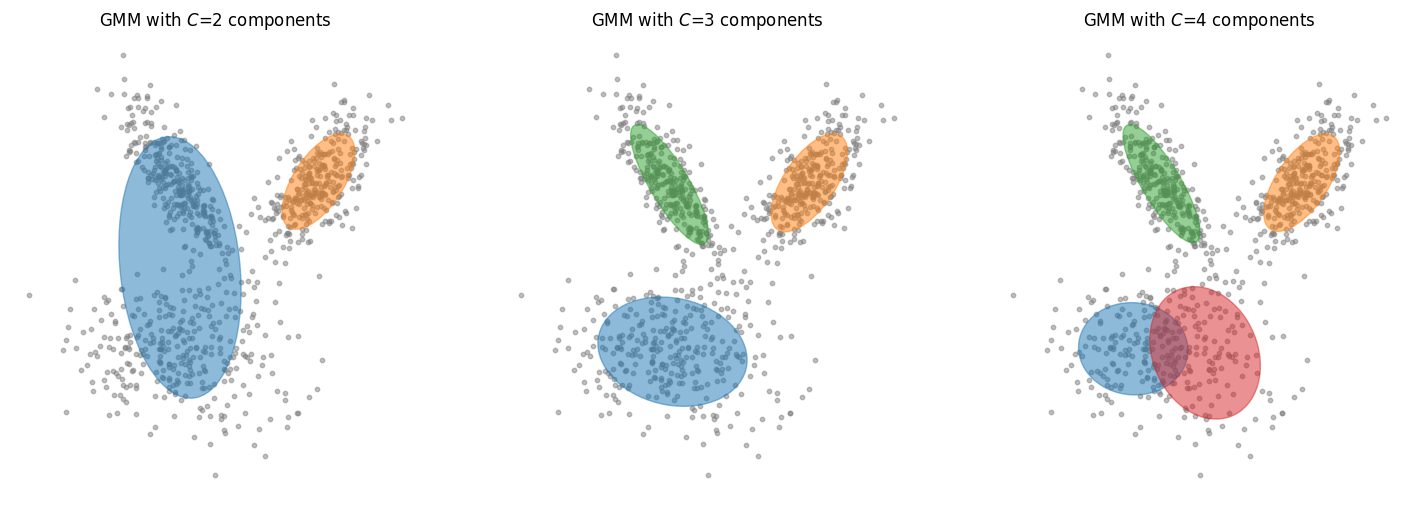

In [49]:
_, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, n in enumerate([2, 3, 4]):
    plot_gmm(X, n, ax=axes[i])
    axes[i].set_title(f"GMM with $C$={n} components")

Математически GMM определяется как:

$$p(x) = \sum_{c=1}^{C} \pi_c \mathcal{N}(x | \mu_c, \Sigma_c)$$

- $\pi_c$ - это коэффициент смешивания $c$-го гауссиана, где $0 \leq \pi_c \leq 1$ и $\sum_{c=1}^{C} \pi_c = 1$.
- $\pi_c$ указывает, насколько точка данных $x$ принадлежит $c$-му гауссиану $\mathcal{N}(x | \mu_c, \Sigma_c)$.

- Кластеризация с GMM включает оценку параметров $\pi_c$, $\mu_c$ и $\Sigma_c$ с использованием алгоритма максимизации ожиданий (EM):
- Алгоритм EM итеративно назначает точки данных кластерам (шаг ожидания).
- Затем обновляет параметры, чтобы максимизировать вероятность данных с учетом текущих кластеров (шаг максимизации).
- В конце каждой точке данных назначается вероятность принадлежности к каждому кластеру.
- Выходом является *мягкая кластеризация*, где точки могут принадлежать нескольким кластерам с разными вероятностями.

- Выходные данные могут быть представлены *мягкой матрицей кластерного назначения* $\boldsymbol{\Pi} \in \mathbb{R}^{N \times C}$.
- $(i,c)$-й элемент $\boldsymbol{\Pi}$ является принадлежностью MTS $i$ к кластеру $c$: $\boldsymbol{\Pi}[i,c] = \pi^{(i)}_c$.
- $i$-я строка $\boldsymbol{\Pi}$ представляет все членства $i$-й MTS: $\boldsymbol{\Pi}[i,:] = \Pi^{(i)}$.
- Четкие кластерные назначения (ячейки серого цвета на рисунке) получаются путем взятия максимального значения в $\Pi^{(i)}$.

<img src="data\l7\soft_clust.png" style="ширина: 35%; дисплей: блок; поля: авто;">

### GMM для временных рядов с пропущенными данными

TCK изменяет стандартную модель GMM двумя способами.

1. Для обработки *данных временных рядов* средние значения модели GMM становятся многомерными временными рядами.
- Стандартная GMM: $\boldsymbol{\mu}_c \in \mathbb{R}^V$.
- TCK GMM: $\boldsymbol{\mu}_c \in \mathbb{R}^{T \times V}$.

2. Для обработки пропущенных значений TCK накладывает априорные значения на параметры GMM и заменяет алгоритм EM на оценку максимального апостериорного значения (MAP).
- EM: $\boldsymbol{\hat \mu}, \boldsymbol{\hat \Sigma} = \text{argmax}_{\boldsymbol{\mu}, \boldsymbol{\Sigma}} p(\mathbf{X} | \boldsymbol{\mu}, \boldsymbol{\Sigma})$.
- MAP с априорными данными: $\boldsymbol{\hat \mu}, \boldsymbol{\hat \Sigma} = \text{argmax}_{\boldsymbol{\mu}, \boldsymbol{\Sigma}} p(\mathbf{X} | \boldsymbol{\mu}, \boldsymbol{\Sigma}) p(\boldsymbol{\mu}, \boldsymbol{\Sigma})$
- Полученные средние значения более гладкие, а параметры аналогичны общему среднему значению и ковариации в кластерах с небольшим количеством выборок.

<img src="data\l7\map.png" style="width: 65%; display: block; margin: auto;">

<div style="text-align: center; font-size: 15px;">Изображение: <a href="https://dl.acm.org/doi/abs/10.1145/2110363.2110408">Марлин и др., 2012 г.</a></div>

#### Ансамблевое обучение

- Ансамблевое обучение: объединение множества слабых моделей для получения более мощной.
- Снижает чувствительность к выбору гиперпараметров.
- Может создавать четко определенное ядро.

- Ансамбль GMM получается путем подгонки $G$ различных GMM на:
- Подмножестве $N$ MTS в наборе данных.
- Подмножестве переменных $V$.
- Сегменте индексов длиной $\leq T$ во временном ряду.

<img src="data\l7\ensemble.png" style="width: 100%; display: block; margin: auto;">

- Матрица ядра получается путем объединения результатов кластеризации из $G$ GMM в ансамбле.
- В частности, $k(\boldsymbol{x}, \boldsymbol{y})$ пропорционально тому, сколько раз $\boldsymbol{x}$ и $\boldsymbol{y}$ назначаются одному и тому же GMM:

$$k(\boldsymbol{x}, \boldsymbol{y}) = \sum \limits_{g \in G} \Pi^{(\boldsymbol{x})}(g)^\top \Pi^{(\boldsymbol{y})}(g)$$

### Классификация с TCK

- Мы загружаем те же данные, что и раньше.

In [50]:
Xtr, Ytr, Xte, Yte = DataLoader().get_data('Japanese_Vowels')

Loaded Japanese_Vowels dataset.
Number of classes: 9
Data shapes:
  Xtr: (270, 29, 12)
  Ytr: (270, 1)
  Xte: (370, 29, 12)
  Yte: (370, 1)


- Одним из главных преимуществ TCK является возможность обработки пропущенных значений.
- Из предыдущих данных мы случайным образом удаляем 40% данных, устанавливая значения на `np.nan`.

In [51]:
mask_tr = np.random.choice([0, 1], size=Xtr.shape, p=[0.6, 0.4])
Xtr[mask_tr == 1] = np.nan
mask_te = np.random.choice([0, 1], size=Xte.shape, p=[0.6, 0.4])
Xte[mask_te == 1] = np.nan

- Мы создаем ядро ​​TCK с `G=30` GMM, каждое с `C=15` компонентами.
- В общем, чем выше значения `G`, тем выше производительность, но тем больше время вычислений.
- `C` контролирует сложность модели. Слишком низкое $\rightarrow$ означает недообучение, слишком высокое $\rightarrow$ означает переобучение.
- Затем мы подгоняем TCK к обучающим данным.
- Как и в случае DTW, мы вычисляем два ядра $K_\text{tr-tr}$ и $K_\text{tr-te}$ для обучения и тестирования нашего классификатора.

In [52]:
tck = TCK(G=30, C=15)
Ktr = tck.fit(Xtr).predict(mode='tr-tr')
Kte = tck.predict(Xte=Xte, mode='tr-te').T
print(f"Ktr shape: {Ktr.shape}\nKte shape: {Kte.shape}")

The dataset contains missing data

Training the TCK using the following parameters:
	C = 15, G = 30
	Number of MTS for each GMM: 216 - 270 (80 - 100 percent)
	Number of attributes sampled from [2, 11]
	Length of time segments sampled from [6, 23]




Computing TCK (tr-te): 100%|██████████| 420/420 [00:11<00:00, 37.45it/s]

Ktr shape: (270, 270)
Kte shape: (370, 270)


**💡 Совет**
- Если TCK занимает слишком много времени, попробуйте уменьшить количество GMM (`G`) или количество компонентов (`C`).

In [53]:
clf = svm.SVC(kernel='precomputed').fit(Ktr, Ytr.ravel()) # Train
Ypred = clf.predict(Kte) # Test
print(f" Test accuracy: {accuracy_score(Yte, Ypred):.2f}")

 Test accuracy: 0.93


- Даже при 40% пропущенных данных с TCK мы сохраняем хорошую эффективность классификации.

---

## Time-series embedding

- Последний подход, который мы рассматриваем, заключается в том, чтобы встроить весь MTS в вектор с действительными значениями.
- Это позволяет нам использовать стандартные меры (несходства) для векторных данных (косинусное сходство, евклидово расстояние и т. д.).
- Ключевая проблема заключается в том, как встроить временную информацию в статический вектор осмысленным образом.

- Существует множество подходов к извлечению статических признаков из временного ряда.
- Например, см. [здесь](https://github.com/fraunhoferportugal/tsfel) для коллекции простых методов.
- В этой лекции мы сосредоточимся на резервуарных вычислениях (RC) для генерации вложений MTS.

### RC-фреймворк

- Мы будем полагаться на [RC-фреймворк для классификации и кластеризации MTS](https://reservoir-computing.readthedocs.io/en/latest/).

<img src="data\l7\RC_classifier.png" style="width: 90%; display: block; margin: auto;">

- Каркас RC состоит из 4 модулей:
1. Модуль резервуара.
2. Модуль снижения размерности.
3. Модуль представления MTS.
4. Модуль считывания.

#### Модуль резервуара

- Этот модуль генерирует последовательность состояний резервуара из заданного MTS $\boldsymbol{x}$ как

$$\mathbf{h}(t) = \sigma \left(\mathbf{W}_i \boldsymbol{x}(t)+\mathbf{W}_h \mathbf{h}(t-1)\right)$$

- Если у нас есть $N$ MTS, они могут быть обработаны Резервуаром параллельно и сгенерировать последовательность состояний

$$\{\mathbf{H}(1), \mathbf{H}(2), \dots, \mathbf{H}(T)\}$$

- с $\mathbf{H}(t) \in \mathbb{R}^{N \times H}$.
- Резервуар может работать в двух модальностях:
1. Однонаправленный.
2. Двунаправленный.

**Однонаправленный резервуар**
- Это тот же резервуар, который мы видели на предыдущих лекциях.
- Вход: данные MTS `X` формы `[N, T, V]`.
- Выход: последовательность состояний `H` формы `[N, T, H]`.
    
<img src="data\l7\unidir.png" style="width: 30%; display: block; margin: auto;">

**Двунаправленный резервуар**
- Этот резервуар обрабатывает временные ряды также в обратном направлении.
- Это позволяет извлекать контекст из прошлых и будущих точек данных, захватывать более сложные и длительные временные зависимости.
- Двунаправленный резервуар не является *причинно-следственным*: его нельзя использовать для прогнозирования, но он подходит для классификации и кластеризации.
- Вход: данные MTS `X` формы `[N, T, V]`.
- Выход: последовательность состояний `H` формы `[N, T, 2*H]`.

<img src="data\l7\bidir.png" style="width: 30%; display: block; margin: auto;">

In [54]:
Xtr, Ytr, Xte, Yte = DataLoader().get_data('Japanese_Vowels')

Loaded Japanese_Vowels dataset.
Number of classes: 9
Data shapes:
  Xtr: (270, 29, 12)
  Ytr: (270, 1)
  Xte: (370, 29, 12)
  Yte: (370, 1)


In [55]:
H_uni = Reservoir(n_internal_units=300).get_states(Xtr, bidir=False)
print(f"Unidir\n  H: {H_uni.shape}")

H_bi = Reservoir(n_internal_units=300).get_states(Xtr, bidir=True)
print(f"Bidir\n  H: {H_bi.shape}")

Unidir
  H: (270, 29, 300)
Bidir
  H: (270, 29, 600)


#### Модуль снижения размерности (опционально)

- Этот модуль снижает размерность состояний Reservor с `[N,T,H]` (или `[N,T,2*H]`) до `[N,T,R]`.
- Этот модуль необязателен, т. е. снижение размерности можно пропустить.
- Однако он значительно ускоряет вычисления, особенно при использовании более сложных представлений (подробнее скоро).
- Снижение размерности можно реализовать с помощью
1. Стандартного PCA
2. Тензорного PCA

<img src="data\l7\dim_red.png" style="width: 30%; display: block; margin: auto;">

**Стандартный PCA**
- Стандартный PCA работает только с одномерными данными.
- Измените `H` с `[N,T,H]` на `[N*T,H]`.
- Примените PCA и сохраните первые компоненты `R`.
- Измените `[N*T,R]` обратно на `[N,T,R]`.
- 🛑 Проблема: выборка и временные шаги перепутаны, а моды изменения во времени в отдельных выборках игнорируются.

**Тензорный PCA**

- Вычислите следующую ковариационную матрицу

$$\mathbf{S} = \frac{1}{N-1} \sum \limits_{n=1}^N (\mathbf{H}_n - \mathbf{\bar H})^\top (\mathbf{H}_n - \mathbf{\bar H}) \in \mathbb{R}^{H \times H}$$

- где $\mathbf{H}_n \in \mathbb{R}^{T \times H}$ получается как `H[n,:,:]` и $\mathbf{\bar H} = \frac{1}{N} \sum \limits_{n=1}^N \mathbf{H}_n \in \mathbb{R}^{T \times H}$.
- Это позволяет вычислять изменения по измерению резервуара, разделяя измерение образца и времени.
- Затем мы берем первые $R$ собственных векторов $\mathbf{S}$: $\mathbf{D} = [\mathbf{u}_1, \mathbf{u}_2, \dots, \mathbf{u}_R]\in \mathbb{R}^{H \times R}$.
- Мы получаем приведенные состояния с помощью следующего умножения матриц: $\mathbf{\hat H}_n = \mathbf{H}_n \mathbf{D}$.

In [56]:
H_red = tensorPCA(n_components=75).fit_transform(H_bi)
print(f"H_red: {H_red.shape}")

H_red: (270, 29, 75)


#### Модуль представления

- Этот модуль отвечает за преобразование последовательности состояний резервуара в векторное представление $\mathbf{r}_\mathbf{X}$.
- Резервуар извлекает и разделяет динамические признаки.
- Кроме того, он сохраняет память обо всех прошлых входных данных.
- Поэтому в некоторых случаях достаточно сохранить только *последнее состояние резервуара* для представления всей MTS.

<img src="data\l7\last_state.png" style="width: 10%; display: block; margin: auto;">

In [57]:
rx_last = H_red[:,-1,:]
print(f"rx_last: {rx_last.shape}")

rx_last: (270, 75)


- На практике, даже при использовании двунаправленного резервуара, это простое представление может не охватить важную информацию в середине временного ряда.

**Пространство выходной модели**

- Более эффективное представление получается следующим образом.
1. Обучить линейный отсчет для прогнозирования MTS на один шаг вперед

$$\boldsymbol{x}(t+1) = \mathbf{h}(t)\mathbf{W}_o + \mathbf{w}_o$$

2. Параметры линейной модели $\boldsymbol{\theta}_o = [\text{vec}(\mathbf{W}_o); \mathbf{w}_o] \in \mathbb{R}^{V(R+1)}$ становятся $\mathbf{r}_\mathbf{X}$.

<img src="data\l7\output_ms.png" style="width: 12%; display: block; margin: auto;">

In [58]:
out_pred = Ridge(alpha=1.0)

# If we use a bidirectional Reservoir we also need to predict the time series backwards
X = np.concatenate((Xtr, Xtr[:, ::-1, :]), axis=2)

coeff, biases = [], []
for i in range(X.shape[0]):
    out_pred.fit(H_red[i, 0:-1, :], X[i, 1:, :])
    coeff.append(out_pred.coef_.ravel())
    biases.append(out_pred.intercept_.ravel())
rx_out = np.concatenate((np.vstack(coeff), np.vstack(biases)), axis=1)

print(f"rx_out: {rx_out.shape}") # [N, 2*V*(R+1)]

rx_out: (270, 1824)


**Пространство модели резервуара**

- Аналогичный подход заключается в использовании коэффициентов линейной модели, которая предсказывает следующее состояние резервуара

$$\mathbf{h}(t+1) = \mathbf{h}(t)\mathbf{W}_h + \mathbf{w}_h$$

- Представление MTS $\mathbf{r}_\mathbf{X}$ становится $\boldsymbol{\theta}_h = [\text{vec}(\mathbf{W}_h); \mathbf{w}_h] \in \mathbb{R}^{R(R+1)}$.

 

<img src="data\l7\reservoir_ms.png" style="width: 15%; display: block; margin: auto;">

In [59]:
res_pred = Ridge(alpha=1.0)

coeff, biases = [], []
for i in range(H_red.shape[0]):
    res_pred.fit(H_red[i, 0:-1, :], H_red[i, 1:, :])
    coeff.append(res_pred.coef_.ravel())
    biases.append(res_pred.intercept_.ravel())
rx_res = np.concatenate((np.vstack(coeff), np.vstack(biases)), axis=1)

print(f"rx_res: {rx_res.shape}") # [N, R*(R+1)]

rx_res: (270, 5700)


- В принципе, пространство модели резервуара $\boldsymbol{\theta}_h$ обеспечивает лучшее представление, чем пространство модели выхода $\boldsymbol{\theta}_o$. Почему 🤔?

- Резервуар генерирует большой пул динамики, но для прогнозирования входных данных на определенном горизонте прогнозирования требуется лишь несколько из них, т. е. 1, если мы прогнозируем $\boldsymbol{x}(t+1)$.
- Поскольку другие динамики не являются полезными для задачи, они отбрасываются, даже если они все еще полезны для характеристики МТС.

- С другой стороны, для прогнозирования следующего состояния резервуара $\mathbf{h}(t+1)$ необходимо учитывать *всю* динамику резервуара.
- Это делает $\boldsymbol{\theta}_h$ более мощным представлением, поскольку оно полностью характеризует MTS.

#### Readout module

- Модуль считывания отвечает за классификацию или кластеризацию представлений MTS.
- Поскольку каждое представление $\mathbf{r}_\mathbf{X}$ является вектором, можно использовать любой стандартный классификатор для векторных данных.
- Аналогично, мы можем использовать стандартные меры (несходства) для векторных данных.
- Например, кластеризация может быть выполнена с использованием аглоритма связей на евклидовых расстояниях между представлениями MTS.

### Классификация с RC-вложениями

- Мы можем использовать высокоуровневую функцию `RC_model` для выполнения классификации.
- Функция принимает в качестве входных данных гиперпараметры для настройки:
    1. модуль Reservoir,
    2. модуль снижения размерности,
    3. модуль представления,
    4. модуль считывания.
- Чтобы все было понятно, давайте сохраним гиперпараметры в словаре Python.

In [60]:
config = {}

# Hyperarameters of the reservoir
config['n_internal_units'] = 450        # size of the reservoir
config['spectral_radius'] = 0.9         # largest eigenvalue of the reservoir
config['leak'] = None                   # amount of leakage in the reservoir state update (None or 1.0 --> no leakage)
config['connectivity'] = 0.25           # percentage of nonzero connections in the reservoir
config['input_scaling'] = 0.1           # scaling of the input weights
config['noise_level'] = 0.01            # noise in the reservoir state update
config['n_drop'] = 5                    # transient states to be dropped
config['bidir'] = True                  # if True, use bidirectional reservoir
config['circle'] = False                # use reservoir with circle topology

# Dimensionality reduction hyperparameters
config['dimred_method'] = 'tenpca'      # options: {None (no dimensionality reduction), 'pca', 'tenpca'}
config['n_dim'] = 75                    # number of resulting dimensions after the dimensionality reduction procedure

# Type of MTS representation
config['mts_rep'] = 'reservoir'         # MTS representation: {'last', 'mean', 'output', 'reservoir'}
config['w_ridge_embedding'] = 10.0      # regularization parameter of the ridge regression

# Type of readout
config['readout_type'] = 'lin'          # readout used for classification: {'lin', 'mlp', 'svm'}
config['w_ridge'] = 5.0                 # regularization of the ridge regression readout

- Мы создаем RC-классификатор, передавая параметры конфигурации.

In [61]:
classifier =  RC_model(**config)

- Мы снова загружаем данные (хорошая практика, позволяющая быть уверенным в получении чистых данных).

In [62]:
Xtr, Ytr, Xte, Yte = DataLoader().get_data('Japanese_Vowels')

Loaded Japanese_Vowels dataset.
Number of classes: 9
Data shapes:
  Xtr: (270, 29, 12)
  Ytr: (270, 1)
  Xte: (370, 29, 12)
  Yte: (370, 1)


- Модель RC ожидает, что метки классов будут иметь  one-hot-encoded, e.g.
- $1 \rightarrow [1, 0, 0, 0 \dots, 0]$, $2 \rightarrow [0, 1, 0, 0 \dots, 0]$, $3 \rightarrow [0, 0, 1, 0 \dots, 0]$, etc..

In [63]:
# One-hot encoding for labels
onehot_encoder = OneHotEncoder(sparse_output=False)
Ytr = onehot_encoder.fit_transform(Ytr)
Yte = onehot_encoder.transform(Yte)

In [64]:
# Train the model
tr_time = classifier.fit(Xtr, Ytr)

Training completed in 0.02 min


In [65]:
# Compute predictions on test data
pred_class = classifier.predict(Xte)
accuracy, f1 = compute_test_scores(pred_class, Yte)
print(f"Accuracy = {accuracy:.3f}, F1-score = {f1:.3f}")

Accuracy = 0.978, F1-score = 0.978


- Обратите внимание, что этот подход значительно быстрее других, которые мы видели до сих пор.

### Кластеризация с RC-вложениями

- Мы выполним следующие шаги:

1. Сгенерируем векторные представления для всех MTS.
2. Вычислим матрицу различий.
3. Выполним кластеризацию с помощью алгоритма HC на основе расстояний Linkage.

- Поскольку мы делаем кластеризацию, нам не нужно разделение на обучающие и тестовые данные.
- Мы объединяем данные из обоих наборов вместе.

In [ ]:
Xtr, Ytr, Xte, Yte = DataLoader().get_data('Japanese_Vowels')

X = np.concatenate((Xtr, Xte), axis=0)
Y = np.concatenate((Ytr, Yte), axis=0)

Loaded Japanese_Vowels dataset.
Number of classes: 9
Data shapes:
  Xtr: (270, 29, 12)
  Ytr: (270, 1)
  Xte: (370, 29, 12)
  Yte: (370, 1)


- Мы можем повторно использовать ту же `RC_model`, что и раньше.
- Единственное отличие в том, что мы не хотим применять модуль считывания.
- Вместо этого он должен возвращать представления MTS.
- Это достигается установкой `'readout_type'` на `None`.

In [67]:
config['readout_type'] = None # We update this entry from the previous config dict

In [ ]:
# Instantiate the RC model
rcm =  RC_model(**config)

# Generate representations of the input MTS
rcm.fit(X)
mts_representations = rcm.input_repr

Training completed in 0.04 min


- На этом этапе мы вычисляем матрицу расстояний, используя стандартные метрики для векторных данных.
- Например, мы можем использовать евклидово или косинусное расстояние.
- Последнее часто предпочтительнее в многомерных пространствах, поскольку евклидово расстояние может стать раздутым и менее значимым («проклятие размерности»).

In [ ]:
# Compute Dissimilarity matrix
Dist = cosine_distances(mts_representations)
distArray = ssd.squareform(Dist)

# Hierarchical clustering
Z = linkage(distArray, 'ward')
clust = fcluster(Z, t=4.0, criterion="distance")
print(f"Found {len(np.unique(clust))} clusters")

# Evaluate the agreement between class and cluster labels
nmi = v_measure_score(Y[:,0], clust)
print(f"Normalized Mutual Information (v-score): {nmi:.3f}")

Found 9 clusters
Normalized Mutual Information (v-score): 0.900


---

## Резюме

Вот что мы рассмотрели в этой лекции.
- Сначала мы представили проблему классификации и кластеризации для векторных данных и важность выбора правильной меры для вычисления (нес)сходств между образцами.
- Затем мы представили три подхода к вычислению (нес)сходств в многомерных временных рядах.

1. DTW, метрика на основе выравнивания.

2. TCK, ядерное сходство.

3. Встраивание RC, подход к встраиванию временных рядов в векторные данные.
- Эти меры (нес)сходства являются краеугольным камнем в классификации и кластеризации временных рядов.
- После вычисления мы увидели, как их можно легко подключить к тому же методу классификации и кластеризации, который мы видели для векторных данных.

В заключение мы выделим основные плюсы и минусы трех подходов к вычислению (не)сходства MTS.

**DTW**

- ✅ В большинстве случаев хорошо работает с гиперпараметрами по умолчанию.
- ✅ Инвариантен к перемещениям во времени.
- ❌ Медленно.
- ❌ Не учитывает сложные динамические особенности.

**TCK**

- ✅ Гиперпараметры легко настраиваются.
- ✅ Обрабатывает отсутствующие данные.
- ❌ Очень медленно.

**RC-embedding**

- ✅ Быстро.
- ✅ Захватывает сложные динамические особенности.
- ❌ Множество гиперпараметров для установки.

- Каждый подход может достигать лучшей или худшей производительности в зависимости от данных и решаемой проблемы.
- Выбор оптимальной меры (несходства), алгоритма классификации/кластеризации и гиперпараметров часто является сложной процедурой.
- Это требует опыта и должно выполняться с использованием систематических подходов, таких как перекрестная проверка.

---

## Упражнения

Мы рассмотрим набор данных [Libras](https://www.timeseriesclassification.com/description.php?Dataset=Libras). Набор данных содержит 15 классов по 24 экземпляра в каждом. Каждый класс ссылается на тип движения руки в LIBRAS (португальское название «LÍngua BRAsileira de Sinais», официальный бразильский язык сигналов).

In [70]:
Xtr, Ytr, Xte, Yte = DataLoader().get_data('Libras')

Loaded Libras dataset.
Number of classes: 15
Data shapes:
  Xtr: (180, 45, 2)
  Ytr: (180, 1)
  Xte: (180, 45, 2)
  Yte: (180, 1)


### Упражнение 1

1. Вычислите матрицу расстояний DTW.

In [71]:
# Concatenate X and Xte
X = np.concatenate((Xtr, Xte), axis=0)
Y = np.concatenate((Ytr, Yte), axis=0)
(X.shape,Y.shape)

((360, 45, 2), (360, 1))

In [72]:
# Compute the dissimilarity matrix
dtw_dist = dtw_ndim.distance_matrix_fast(X)
dtw_dist.shape

(360, 360)

2. Получите из нее матрицу сходства.

In [73]:
dtw_sim = 1.0 - dtw_dist/dtw_dist.max()

3. Постройте две матрицы. Прокомментируйте структуру, которую вы видите (не забудьте отсортировать элементы по классам).

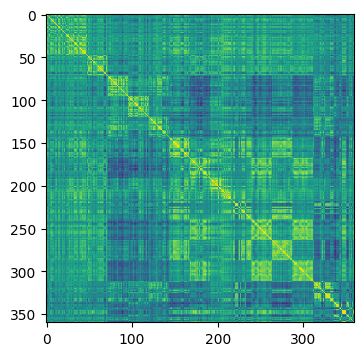

In [74]:
# Plot the similarity matrix
idx_sorted = np.argsort(Y[:,0])
dtw_sim_sorted = dtw_sim[:,idx_sorted][idx_sorted,:]
fig =  plt.figure(figsize=(4,4))
plt.imshow(dtw_sim_sorted);

видны жёлтые области одного класса, где расстояние близко к нулю

In [75]:
# построим две матрицы сходства
# tr-tr - на ней учимся
sim_trtr = dtw_sim[:Xtr.shape[0], :Xtr.shape[0]]
print(sim_trtr.shape)

# te-tr - на ней предсказываем 
# на ней оцениваем на сколько объекты теста схожи с объектами обучающей выборки
sim_tetr = dtw_sim[Xtr.shape[0]:, :Xtr.shape[0]]
print(sim_tetr.shape)

(180, 180)
(180, 180)


4. Выполните классификацию с помощью классификаторов SVC и $k$-NN и сообщите:
- время обучения и тестирования,
- точность и оценку F1 на тестовом наборе.

In [76]:
clf = svm.SVC(kernel='precomputed', C=1).fit(sim_trtr, Ytr.ravel())
y_pred = clf.predict(sim_tetr)
accuracy = accuracy_score(y_pred, Yte.ravel())
f1 = f1_score(Yte.ravel(), y_pred, average='macro')
print(f"SVC Accuracy: {accuracy*100:.2f}%")
print(f"SVC F1: {f1*100:.2f}%")

SVC Accuracy: 74.44%
SVC F1: 73.87%


In [77]:
# для KNN нужны расстояния
dtw_trtr = dtw_dist[:Xtr.shape[0], :Xtr.shape[0]]
dtw_tetr = dtw_dist[Xtr.shape[0]:, :Xtr.shape[0]]

neigh = KNeighborsClassifier(n_neighbors=3, metric='precomputed') # specify k=3
neigh.fit(dtw_trtr, Ytr.ravel())
y_pred = neigh.predict(dtw_tetr)

accuracy = accuracy_score(y_pred, Yte.ravel())
f1 = f1_score(Yte.ravel(), y_pred, average='macro')
print(f"KNN Accuracy: {accuracy*100:.2f}%")
print(f"KNN F1: {f1*100:.2f}%")

KNN Accuracy: 83.33%
KNN F1: 82.78%


5. Выполните иерархическую кластеризацию с помощью алгоритма Linkage Ward.

In [78]:
distArray = ssd.squareform(dtw_dist)
Z = linkage(distArray, 'ward')

6. Постройте дендрограмму и проверьте ее, чтобы выбрать оптимальный порог для генерации кластерного раздела. Сообщите NMI для найденного вами раздела.

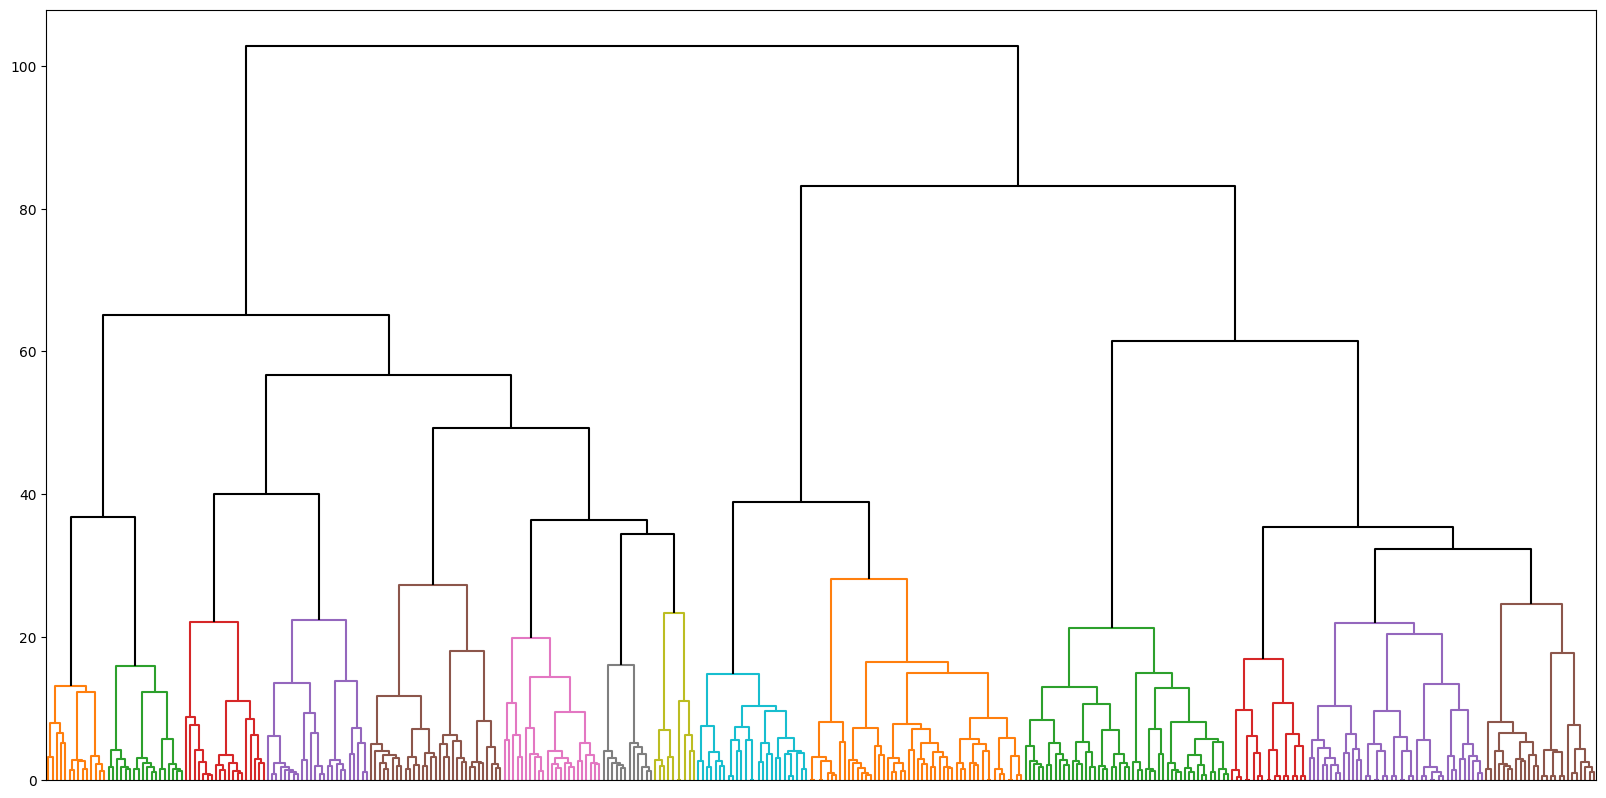

In [79]:
fig = plt.figure(figsize=(20, 10))
dn = dendrogram(Z, color_threshold=30, above_threshold_color='k',
                show_leaf_counts=False)
plt.xticks([]);

In [80]:
partition = fcluster(Z, t=30, criterion="distance")
print(f"Found {len(np.unique(partition))} clusters")

Found 14 clusters


In [81]:
print(f"DTW-based clustering NMI: {v_measure_score(partition, Y.ravel()):.2f}")

DTW-based clustering NMI: 0.63


7. Выполните снижение размерности с помощью KernelPCA. Постройте результаты на двумерном графике.

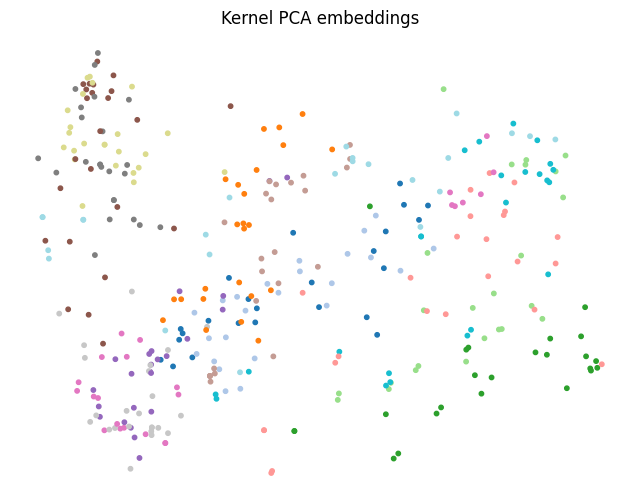

In [82]:
kpca = KernelPCA(n_components=2, kernel='precomputed')
embeddings_pca = kpca.fit_transform(dtw_sim)

fig =  plt.figure(figsize=(8,6))
plt.scatter(embeddings_pca[:,0], embeddings_pca[:,1], c=Y.ravel(), s=10, cmap='tab20')
plt.title("Kernel PCA embeddings")
plt.gca().spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.xticks(())
plt.yticks(());

### Упражнение 2

In [83]:
Xtr, Ytr, Xte, Yte = DataLoader().get_data('Libras')

Loaded Libras dataset.
Number of classes: 15
Data shapes:
  Xtr: (180, 45, 2)
  Ytr: (180, 1)
  Xte: (180, 45, 2)
  Yte: (180, 1)



1. Добавьте 40% пропущенных значений к обучающим и тестовым данным.

In [84]:
mask_tr = np.random.choice([0, 1], size=Xtr.shape, p=[0.6, 0.4])
Xtr[mask_tr == 1] = np.nan
mask_te = np.random.choice([0, 1], size=Xte.shape, p=[0.6, 0.4])
Xte[mask_te == 1] = np.nan

2. Вычислите ядро ​​TCK.

In [85]:
tck = TCK(G=30, C=15)
Ktr = tck.fit(Xtr).predict(mode='tr-tr')
Kte = tck.predict(Xte=Xte, mode='tr-te').T
print(f"Ktr shape: {Ktr.shape}\nKte shape: {Kte.shape}")

The dataset contains missing data

Training the TCK using the following parameters:
	C = 15, G = 30
	Number of MTS for each GMM: 144 - 180 (80 - 100 percent)
	Number of attributes sampled from [2, 2]
	Length of time segments sampled from [6, 25]




Computing TCK (tr-te): 100%|██████████| 420/420 [00:06<00:00, 64.55it/s]

Ktr shape: (180, 180)
Kte shape: (180, 180)


3. Вычислите матрицу различий из ядра (попробуйте сделать дополнительное к тому, что вы сделали для получения сходства из DTW).

In [86]:
# объекты на диагонали сами себе схожи - и это максимум схожести
print(np.unique(np.diag(Ktr)),np.max(Ktr),np.max(Kte))
# и похоже ядро должно быть положиельным
print(np.min(Ktr),np.min(Kte))

[420.] 420.0 412.5205956168234
0.011228788806366928 0.0027538627269997114


In [87]:
k_norm = np.max(Ktr) 
dist_trtr = - np.log(Ktr/k_norm)
dist_tetr = - np.log(Kte/k_norm)
print(np.min(dist_trtr),np.max(dist_trtr))

-0.0 10.529529080721439


4. Выполните классификацию с помощью классификаторов SVC и $k$-NN и сообщите:
- время обучения и тестирования,
- точность и оценку F1 на тестовом наборе.

In [88]:
sim_trtr = Ktr
sim_tetr = Kte
clf = svm.SVC(kernel='precomputed', C=1).fit(sim_trtr, Ytr.ravel())
y_pred = clf.predict(sim_tetr)
accuracy = accuracy_score(y_pred, Yte.ravel())
f1 = f1_score(Yte.ravel(), y_pred, average='macro')
print(f"SVC Accuracy: {accuracy*100:.2f}%")
print(f"SVC F1: {f1*100:.2f}%")

SVC Accuracy: 80.00%
SVC F1: 79.96%


In [89]:
# для KNN нужны расстояния
neigh = KNeighborsClassifier(n_neighbors=3, metric='precomputed') # specify k=3
neigh.fit(dist_trtr, Ytr.ravel())
y_pred = neigh.predict(dist_tetr)

accuracy = accuracy_score(y_pred, Yte.ravel())
f1 = f1_score(Yte.ravel(), y_pred, average='macro')
print(f"KNN Accuracy: {accuracy*100:.2f}%")
print(f"KNN F1: {f1*100:.2f}%")

KNN Accuracy: 63.33%
KNN F1: 62.22%


5. Выполните иерархическую кластеризацию с помощью алгоритма Linkage Ward.

In [90]:
distArray = ssd.squareform(dist_trtr)
Z = linkage(distArray, 'ward')

6. Постройте дендрограмму и проверьте ее, чтобы выбрать оптимальный порог для генерации кластерного раздела. Сообщите NMI для найденного вами раздела.

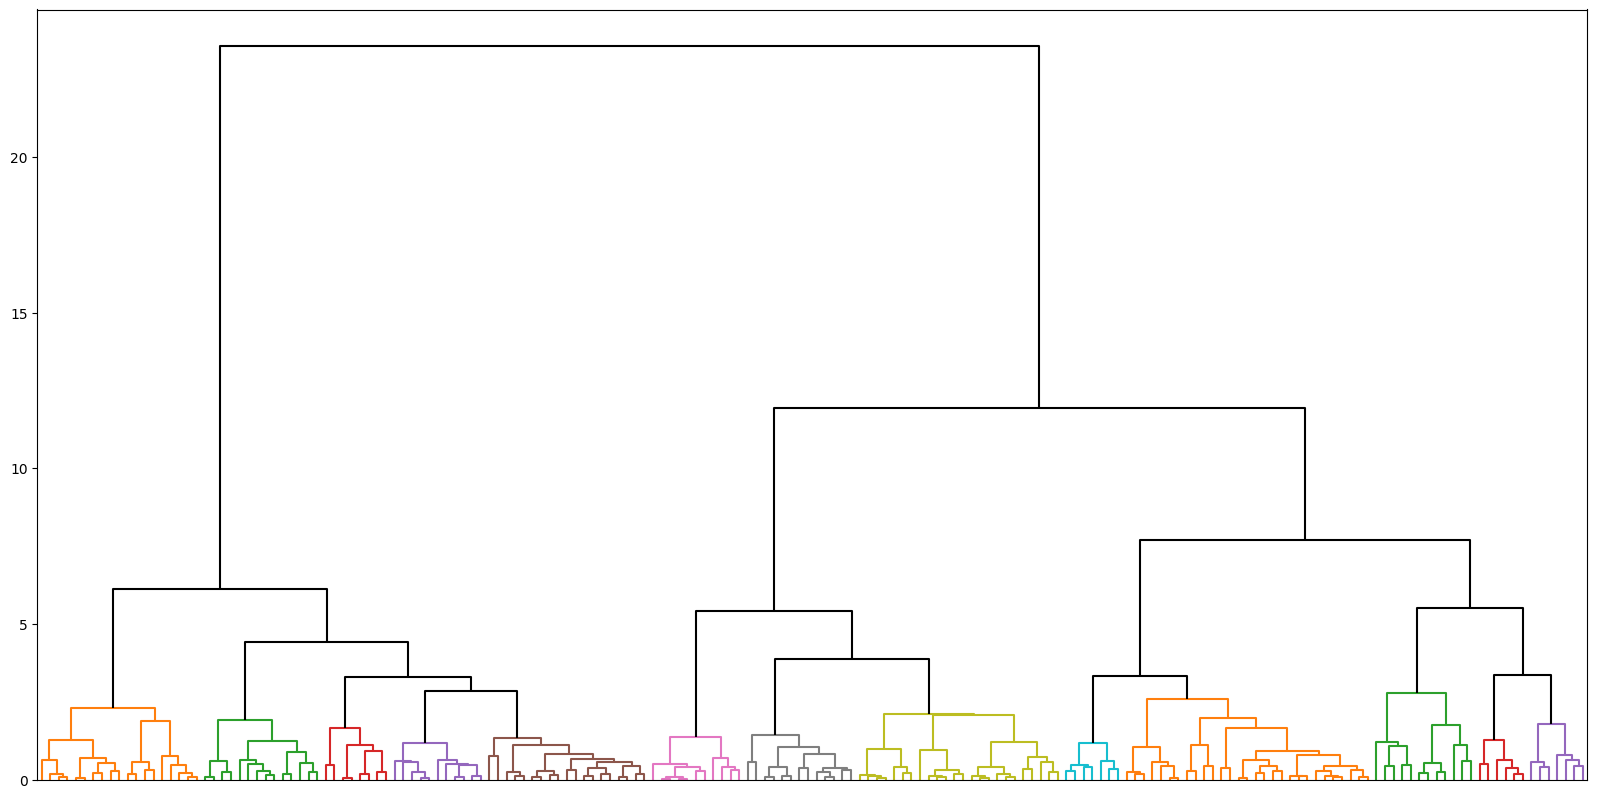

In [91]:
fig = plt.figure(figsize=(20, 10))
dn = dendrogram(Z, color_threshold=2.8, above_threshold_color='k',
                show_leaf_counts=False)
plt.xticks([]);

In [92]:
partition = fcluster(Z, t=2.8, criterion="distance")
print(f"Found {len(np.unique(partition))} clusters")

Found 13 clusters


In [93]:
print(f"DTW-based clustering NMI: {v_measure_score(partition, Ytr.ravel()):.2f}")

DTW-based clustering NMI: 0.54


7. Выполните снижение размерности с помощью KernelPCA. Постройте результаты на двумерном графике.

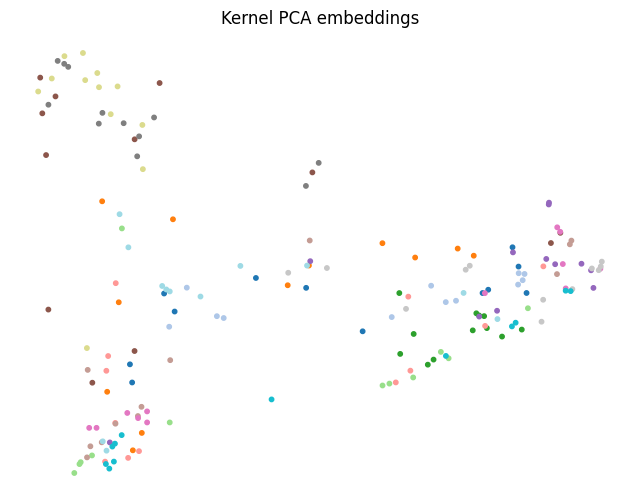

In [94]:
kpca = KernelPCA(n_components=2, kernel='precomputed')
embeddings_pca = kpca.fit_transform(Ktr)

fig =  plt.figure(figsize=(8,6))
plt.scatter(embeddings_pca[:,0], embeddings_pca[:,1], c=Ytr.ravel(), s=10, cmap='tab20')
plt.title("Kernel PCA embeddings")
plt.gca().spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.xticks(())
plt.yticks(());

### Упражнение 3

In [95]:
Xtr, Ytr, Xte, Yte = DataLoader().get_data('Libras')

Loaded Libras dataset.
Number of classes: 15
Data shapes:
  Xtr: (180, 45, 2)
  Ytr: (180, 1)
  Xte: (180, 45, 2)
  Yte: (180, 1)


1. Вычислите RC-вложения.

In [ ]:
config = {}

# Hyperarameters of the reservoir
config['n_internal_units'] = 450        # size of the reservoir
config['spectral_radius'] = 0.9         # largest eigenvalue of the reservoir
config['leak'] = None                   # amount of leakage in the reservoir state update (None or 1.0 --> no leakage)
config['connectivity'] = 0.25           # percentage of nonzero connections in the reservoir
config['input_scaling'] = 0.1           # scaling of the input weights
config['noise_level'] = 0.01            # noise in the reservoir state update
config['n_drop'] = 5                    # transient states to be dropped
config['bidir'] = True                  # if True, use bidirectional reservoir
config['circle'] = False                # use reservoir with circle topology

# Dimensionality reduction hyperparameters
config['dimred_method'] = 'tenpca'      # options: {None (no dimensionality reduction), 'pca', 'tenpca'}
config['n_dim'] = 75                    # number of resulting dimensions after the dimensionality reduction procedure

# Type of MTS representation
config['mts_rep'] = 'reservoir'         # MTS representation: {'last', 'mean', 'output', 'reservoir'}
config['w_ridge_embedding'] = 10.0      # regularization parameter of the ridge regression

# Type of readout
config['readout_type'] = 'lin'          # readout used for classification: {'lin', 'mlp', 'svm'}
config['w_ridge'] = 5.0                 # regularization of the ridge regression readout

In [97]:
config['readout_type'] = None # We update this entry from the previous config dict

2. Получите матрицу сходства и различия из представлений MTS.

In [100]:
# не понял как можно использовать внутреннее векторное представление для классификации.
# в доке есть пример как его использовать для кластеризации
# но как получить представление для теста непонятно

# дальше только про кластеоизацию
X = np.concatenate((Xtr, Xte), axis=0)
Y = np.concatenate((Ytr, Yte), axis=0)
print(X.shape, Y.shape)

# Instantiate the RC model
rcm =  RC_model(**config)

# Generate representations of the input MTS
rcm.fit(X)
mts_representations = rcm.input_repr
print(mts_representations.shape)

(360, 45, 2) (360, 1)
Training completed in 0.03 min
(360, 5700)


In [122]:
# различия - dissimilarity
dist = cosine_distances(mts_representations)
# similarity
sim = cosine_similarity(mts_representations)

4. Выполните классификацию с помощью классификаторов SVC и $k$-NN

azot : понял как это сделать только для кластеризации

5. Выполните иерархическую кластеризацию с помощью алгоритма Linkage Ward.

In [123]:
distArray = ssd.squareform(dist)
Z = linkage(distArray, 'ward')

6. Постройте дендрограмму и проверьте ее, чтобы выбрать оптимальный порог для генерации кластерного раздела. Сообщите NMI для найденного вами раздела.

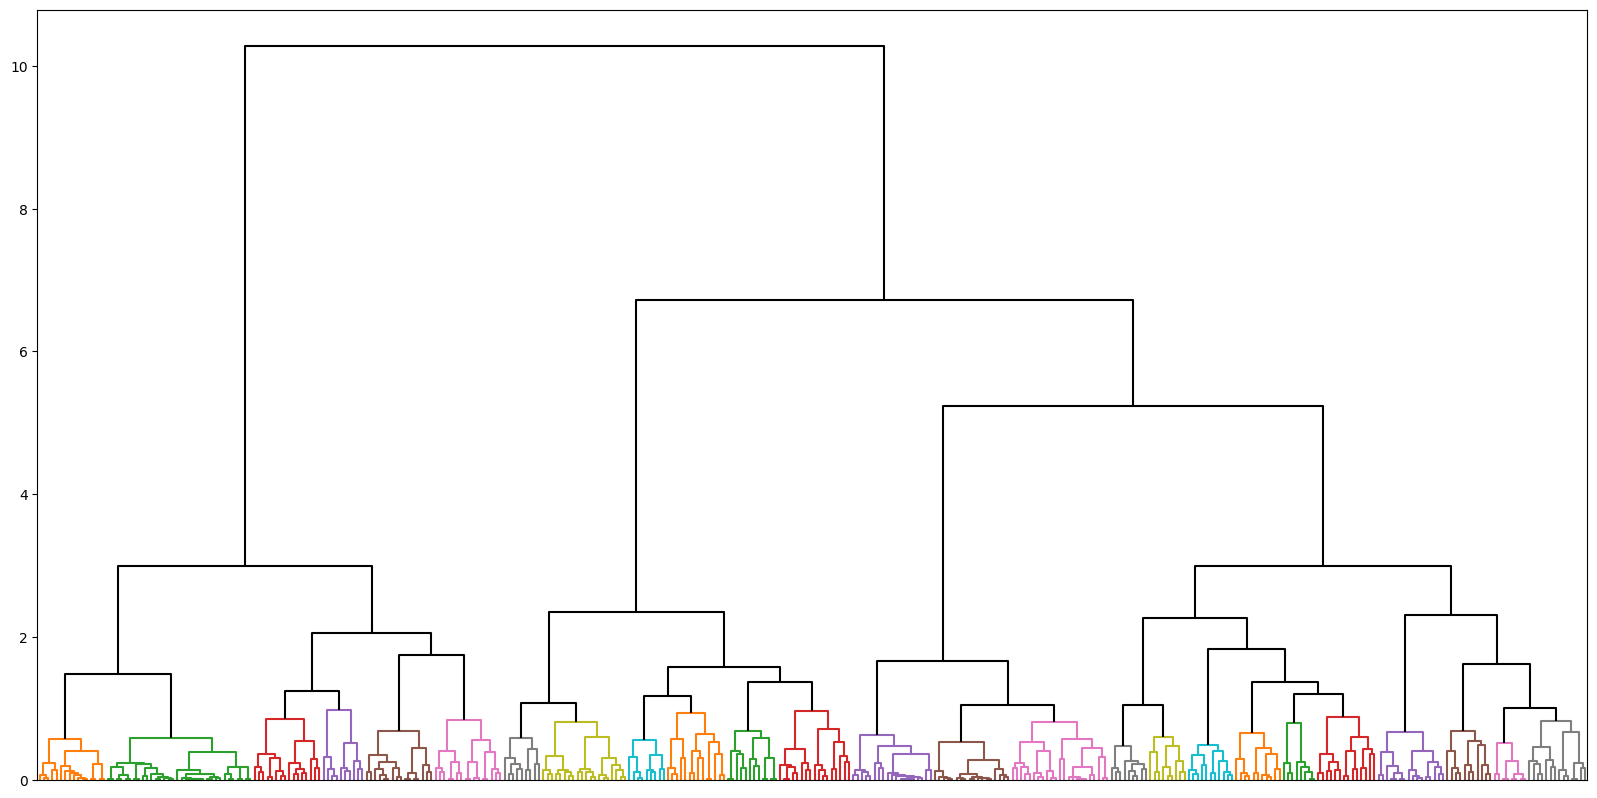

In [136]:
fig = plt.figure(figsize=(20, 10))
dn = dendrogram(Z, color_threshold=1., above_threshold_color='k',
                show_leaf_counts=False)
plt.xticks([]);

In [137]:
partition = fcluster(Z, t=1., criterion="distance")
print(f"Found {len(np.unique(partition))} clusters")

Found 25 clusters


In [138]:
print(f"DTW-based clustering NMI: {v_measure_score(partition, Y.ravel()):.2f}")

DTW-based clustering NMI: 0.46


7. Выполните снижение размерности с помощью KernelPCA. Постройте результаты на двумерном графике.

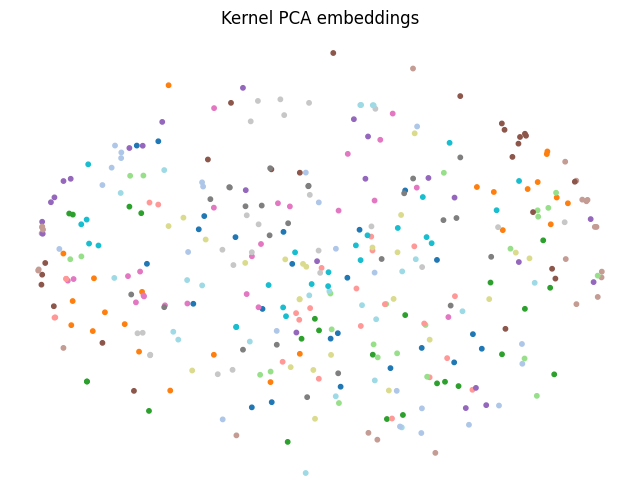

In [139]:
kpca = KernelPCA(n_components=2, kernel='precomputed')
embeddings_pca = kpca.fit_transform(sim)

fig =  plt.figure(figsize=(8,6))
plt.scatter(embeddings_pca[:,0], embeddings_pca[:,1], c=Y.ravel(), s=10, cmap='tab20')
plt.title("Kernel PCA embeddings")
plt.gca().spines[['right', 'left', 'top', 'bottom']].set_visible(False)
plt.xticks(())
plt.yticks(());